# 1 - Perkenalan

Novanska Aginta Ganesha RMT-019

Dataset : disaster twit : (https://www.kaggle.com/competitions/nlp-getting-started/data)

Objective : 
1. Membuat model untuk memprediksi apakah tweet tersebut disaster atau tidak
2. Memberikan insight untuk improve apakah tweets tersebut disaster atau tidak untuk mengurangi tingkat disaster pada tweets.



# 2 - Import Libraries

In [497]:
#Model EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import train test split
from sklearn.model_selection import train_test_split

#preprocessing
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from collections import defaultdict
# Library wordcloud
from wordcloud import WordCloud

# model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, Activation, LSTM, GRU, TextVectorization, Embedding
from tensorflow.keras import Model

# metrics
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix, roc_auc_score 
from collections import Counter

# 3 - Data Loading

In [498]:
df_train = pd.read_csv('D:\Hacktiv8\p2---ftds-019-rmt---m2-Novanska\set-train.csv')

In [499]:
print('Train Shape : ',df_train.shape)

Train Shape :  (7613, 5)


In [500]:
df_train.head(5)

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [501]:
df_train.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [502]:
#check missing values
null_counts = pd.DataFrame({"Num_Null": df_train.isnull().sum()})
null_counts["Persentasi_Null"] = null_counts["Num_Null"] / df_train.count() * 100
null_counts

Num_Null  Persentasi_Null
id               0         0.000000
keyword         61         0.807733
location      2533        49.862205
text             0         0.000000
target           0         0.000000

Insight :

ada sebanyak 61 missing values pada kolom keyword,2533 missing values(49%) pada kolom location

In [503]:
df_train.duplicated().sum()

0

In [504]:
df_train['target'].unique()

array([1, 0], dtype=int64)

terdapat dua kategori apakah data tersebut disaster atau tidak

0 : *non disaster*

1 : *disaster*

# 4 - EDA (Exploratory Data Analysis) Sebelum Preprocessing

In [505]:
eda = df_train.copy()

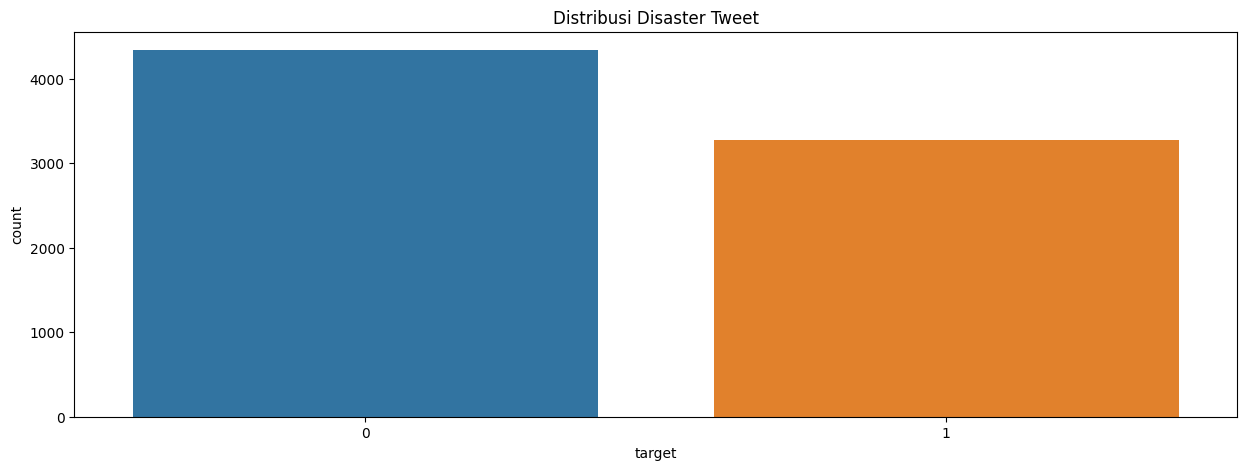

In [230]:
#check distribusi pada target
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x = 'target',data= eda)
plt.title('Distribusi Disaster Tweet')
plt.show()

Insight : 

Dari data diatas terlihat bahwa non disaster tweet lebih banyak dibanding dengan disaster tweet.

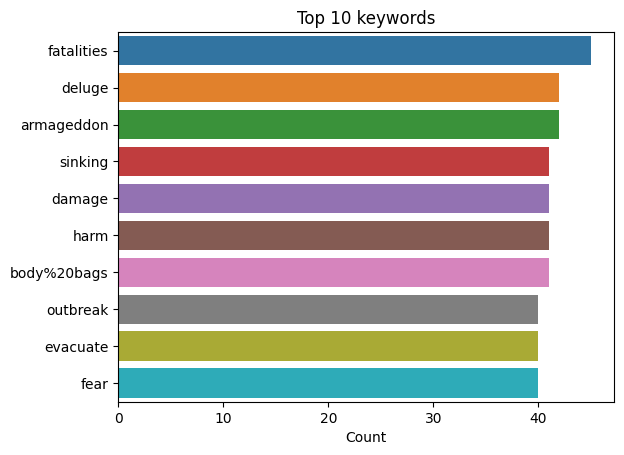

In [231]:
#check 10 top keywords

keywords = pd.DataFrame({'Count': eda['keyword'].value_counts()})
sns.barplot(y=keywords[0:10].index, x = keywords[0:10]['Count'])
plt.title('Top 10 keywords')
plt.show()

Insight :

fatalities merupakan top keyword dari 221 keyword lainnya.

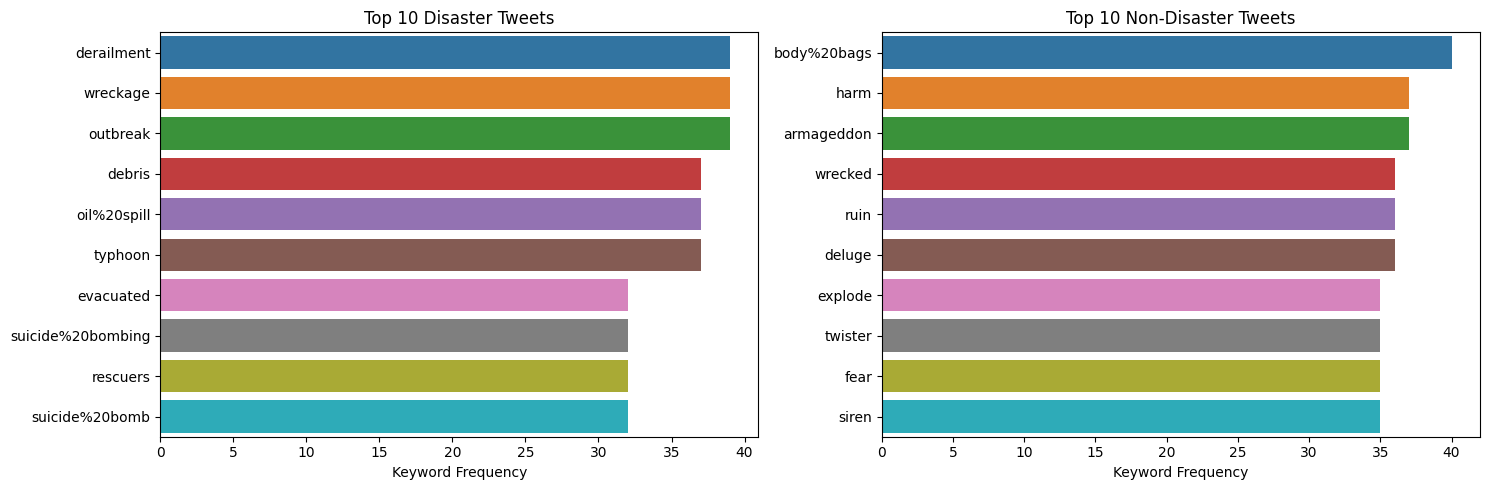

In [232]:
#check top 10 keyword disaster dan non disaster

disaster_word = eda.loc[eda['target']==1]['keyword'].value_counts()
nondisaster_word = eda.loc[eda['target']==0]['keyword'].value_counts()

fig,ax= plt.subplots(1,2, figsize=(15,5))
sns.barplot(y=disaster_word[0:10].index, x=disaster_word[0:10], ax=ax[0])
sns.barplot(y=nondisaster_word[0:10].index, x=nondisaster_word[0:10],ax=ax[1])
ax[0].set_title("Top 10 Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 10 Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

Insight :

derailment merupakan top disaster tweet dan body%20bags merupakan top non-disaster tweets.

dari data diatas kita juga bisa mengkategorikan tweet yang mengandung **armagedon** di non-disaster tweets menjadi keyword **armagedon**

In [233]:
armageddon_tweets = eda[(eda["keyword"].fillna("").str.contains("armageddon")) & (eda["target"] == 0)]
print("Contoh tweet :\n", armageddon_tweets.iloc[11,3 ])
armageddon_tweets.head()

Contoh tweet :
 'If I'd have had a long coat to hand I'd have worn it. The certainty of armageddon bears a sense of occasion.'


id     keyword                   location  \
304  446  armageddon  California, United States   
305  447  armageddon  California, United States   
306  448  armageddon           #FLIGHTCITY UK     
307  450  armageddon                        NaN   
308  451  armageddon                        NaN   

                                                  text  target  
304  #PBBan (Temporary:300) avYsss @'aRmageddon | D...       0  
305  #PBBan (Temporary:300) Russaky89 @'aRmageddon ...       0  
306  ((OFFICIAL VID)) #DoubleCups &gt;&gt; https://...       0  
307                ouvindo Peace Love &amp; Armageddon       0  
308  Best movie you've ever seen? - Armageddon  htt...       0

**Location**

dari mana saja tweet berasal? mari melihat 10 lokasi terbanyak dari data tweet.

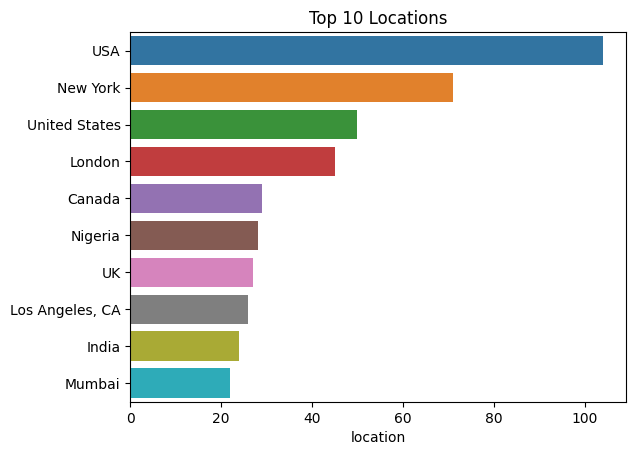

In [506]:
# top 10 locations 
locations_vc = eda["location"].value_counts()
sns.barplot(y=locations_vc[0:10].index, x=locations_vc[0:10])
plt.title("Top 10 Locations")
plt.show()

Insight :

terlihat bahwa USA merupakan lokasi berasal terbanyak dari total tweet yang ada dari 3341 lokasi yang diketahui.

**Check top 10 location pada tweets.**

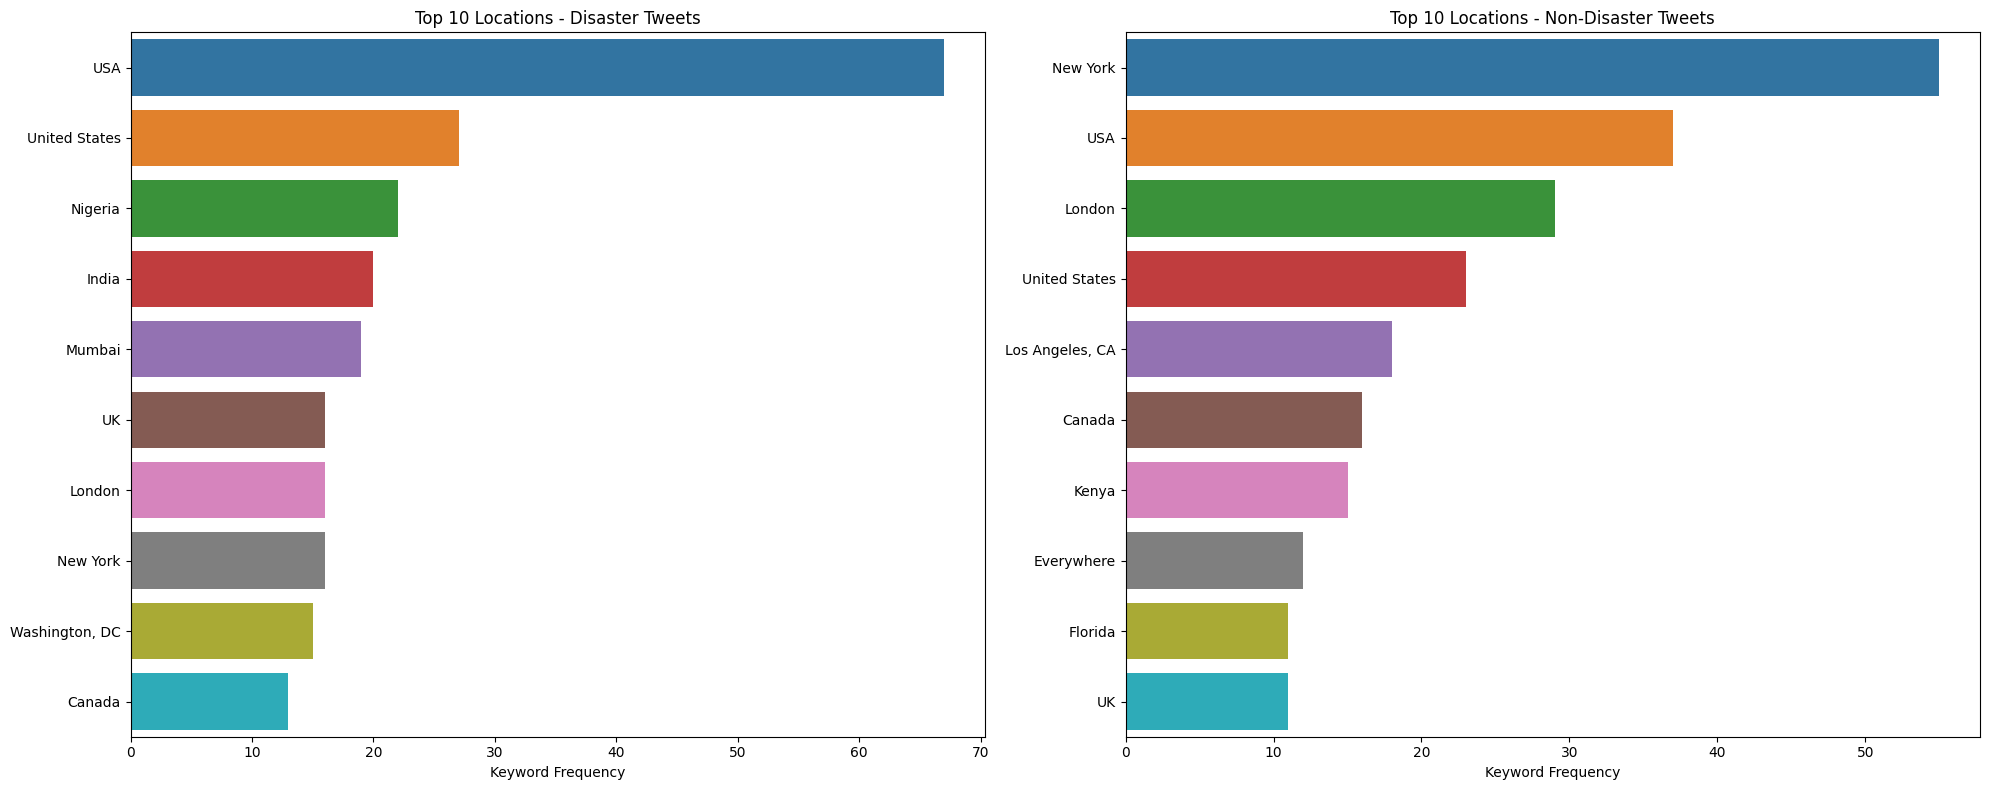

In [235]:
#check top 10 locations
disaster_locations = eda.loc[eda["target"] == 1]["location"].value_counts()
nondisaster_locations = eda.loc[eda["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:10].index, x=disaster_locations[0:10],ax=ax[0])
sns.barplot(y=nondisaster_locations[0:10].index, x=nondisaster_locations[0:10],ax=ax[1])
ax[0].set_title("Top 10 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 10 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

Insight :

Kebanyakan disaster tweets berasal dari USA dan non-disaster tweets berasal dari New York.

**Total karakter terbanyak/terkecil pada tweets dan Panjang kalimat pada tweets**



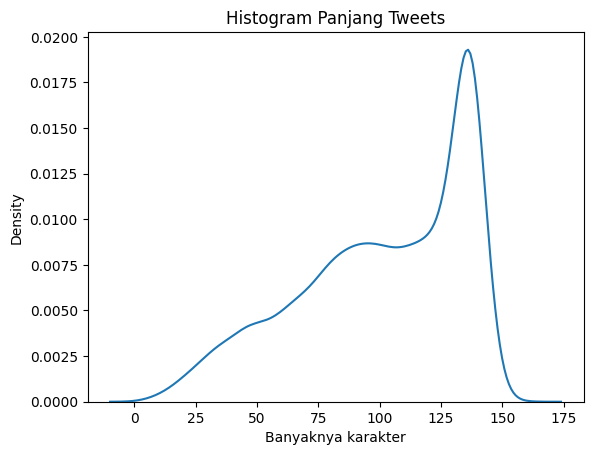

In [236]:
#check total karakter terbanyak dan terkecil pada tweets, dan distribusinya.

eda["tweet_length"] = eda["text"].apply(len)
sns.kdeplot(eda["tweet_length"])
plt.title("Histogram Panjang Tweets")
plt.xlabel("Banyaknya karakter")
plt.ylabel("Density")
plt.show()

In [237]:
#check jumlah karakter terkecil dan terbesar
min(eda["tweet_length"]), max(eda["tweet_length"])

(7, 157)

In [238]:
#check rata-rata pada panjang tweet.
eda['tweet_length'].mean()

101.03743596479706

Insight :

bisa dilihat bahwa karakter terkecil ada di 7 karakter dan terbanyak berada pada 157 karakter.

In [239]:
# check jumlah kata pada setiap tweet.
eda['tweet_sentences_length'] = eda['text'].apply(lambda x: len(nltk.word_tokenize(x)))
eda

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  tweet_length  \
0     Our Deeds are the Reason of this #earthquake M...       1            69   
1                Forest fire near La Ronge Sask. Canada       1            38   
2     All residents asked to 'shelter in place' are ...       1           133   
3     13,000 people receive #wildfires evacuation or...       1            65   
4     Just got sent this photo from Ruby #Alaska as ...       1            88   
...                                                 ...     ...           ...   
7608  Two giant cranes holding a bridge collapse int...       1            83   
7609  @aria_ahrary @TheTawniest The out of control w...       1           125   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1            65   
7611  Police investigating after an e-bike collided ...       1           137   
7612  The Latest: More Homes Razed by Northern Calif...       1            94   

      tweet_sentences_length  
0                         14  
1                          8  
2                         24  
3                          9  
4                         18  
...                      ...  
7608                      13  
7609                      24  
7610                      15  
7611                      21  
7612                      16  

[7613 rows x 7 columns]

In [240]:
min(eda["tweet_sentences_length"]), max(eda["tweet_sentences_length"])

(1, 72)

In [241]:
eda['tweet_sentences_length'].mean()

18.916327334822014

Insight :

Dapat diketahui bahwa yang terkecil hanya 1 kalimat saja pada tweets dan terbesar berada pada 72 kalimat pada satu tweets dengan rata-rata 18 kalimat.

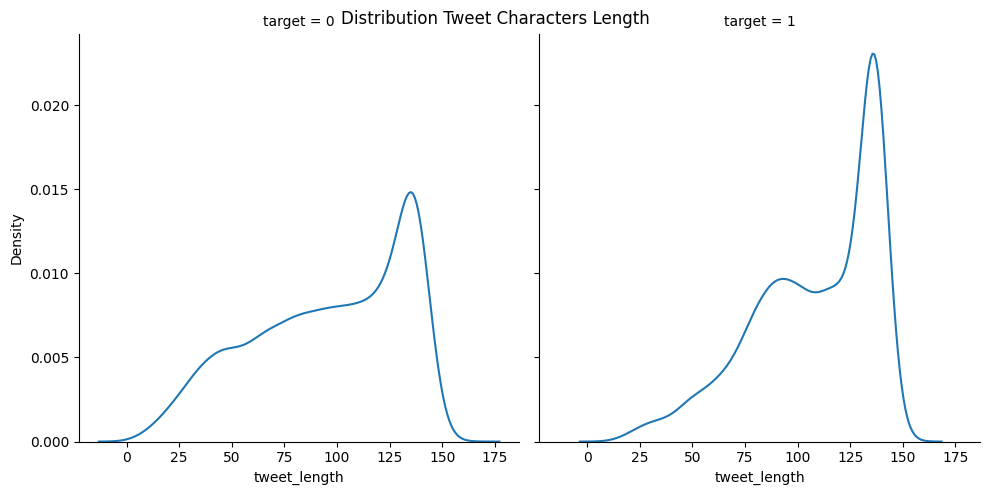

In [242]:
#check panjang karakter pada tweet dari disaster/non disaster tweets
disaster_nondisaster = sns.FacetGrid(eda, col="target", height=5)
disaster_nondisaster = disaster_nondisaster.map(sns.kdeplot, "tweet_length")
plt.suptitle("Distribution Tweet Characters Length")
plt.show()

Insight :

Dari plot data diatas terlihat bahwa  disaster tweet memiliki jumlah yang lumayan banyak diantara 130-150.

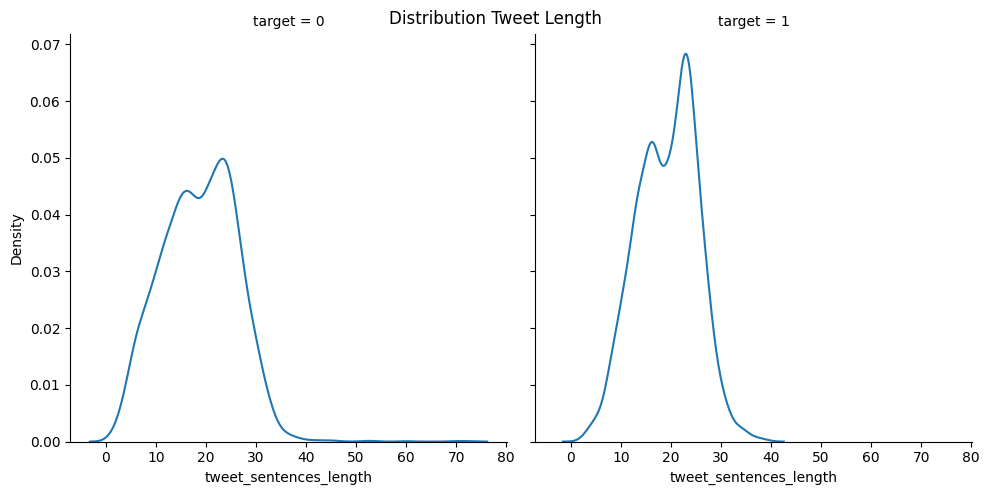

In [243]:
#check panjang tweet dari disaster/non disaster tweets
tweets_len = sns.FacetGrid(eda, col="target", height=5)
tweets_len = tweets_len.map(sns.kdeplot, "tweet_sentences_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

**Wordcloud tweets**

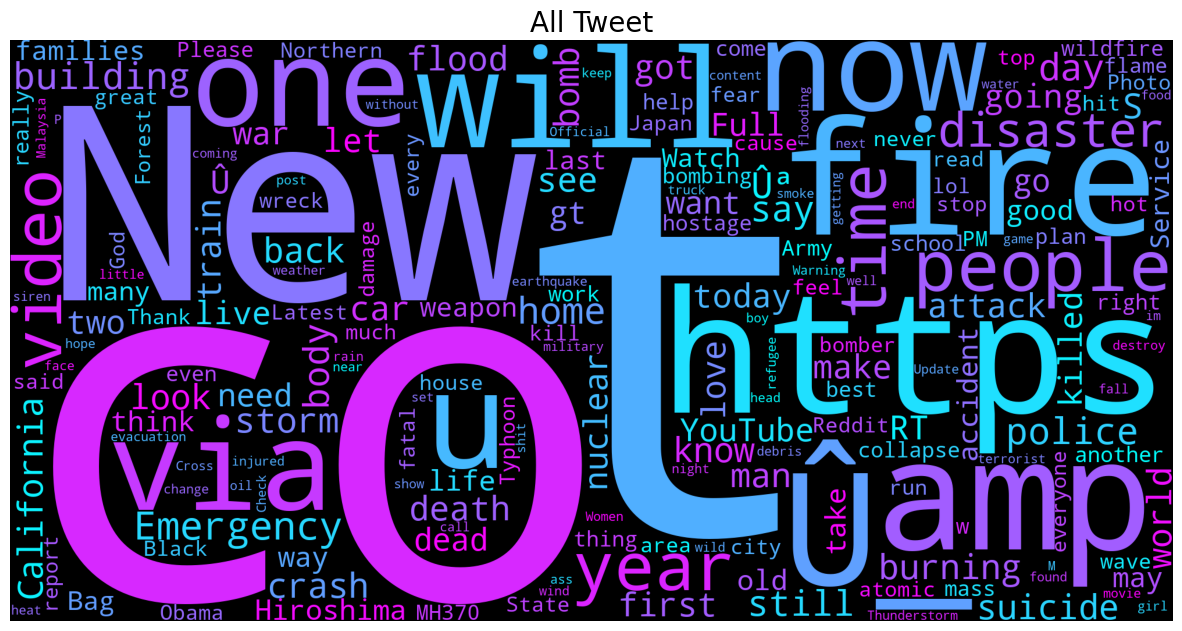

In [244]:
tweets_text = eda.text.values
cloud_text = WordCloud(background_color='black',colormap="cool",collocations=False,width=2000,height=1000).generate(" ".join(tweets_text))


# Menampilkan wordcloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title("All Tweet",fontsize=20)
plt.imshow(cloud_text)

In [245]:
#top 10 highest
eda['tweet_list'] = eda['text'].apply(lambda x:str(x).split())
high_all = Counter([item for sublist in eda['tweet_list'] for item in sublist])
high_tweet_all = pd.DataFrame(high_all.most_common(10))
high_tweet_all.columns = ['Words','Count']
high_tweet_all

Words  Count
0   the   2575
1     a   1845
2    to   1805
3    in   1757
4    of   1722
5   and   1302
6     I   1197
7   for    820
8    is    814
9    on    773

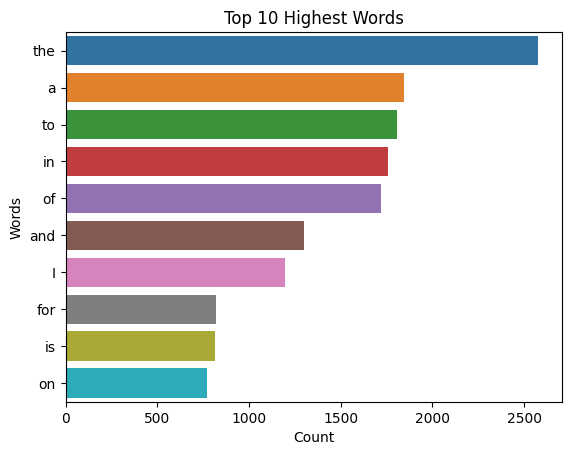

In [246]:
sns.barplot(x='Count',y='Words',data=high_tweet_all)
plt.title('Top 10 Highest Words')
plt.show()

Insight :

Dari data diatas dapat diketahui bahwa :
1. Pada all tweets diketahui bahwa *New*,*https*,*fire*,*now*,*co*,*Will* adalah kata yang paling sering digunakan
2. Terdapat website karena ada kata *https*
3. Terdapat ing verb seperti burning, getting, going

**Wordcloud Disaster Tweets**


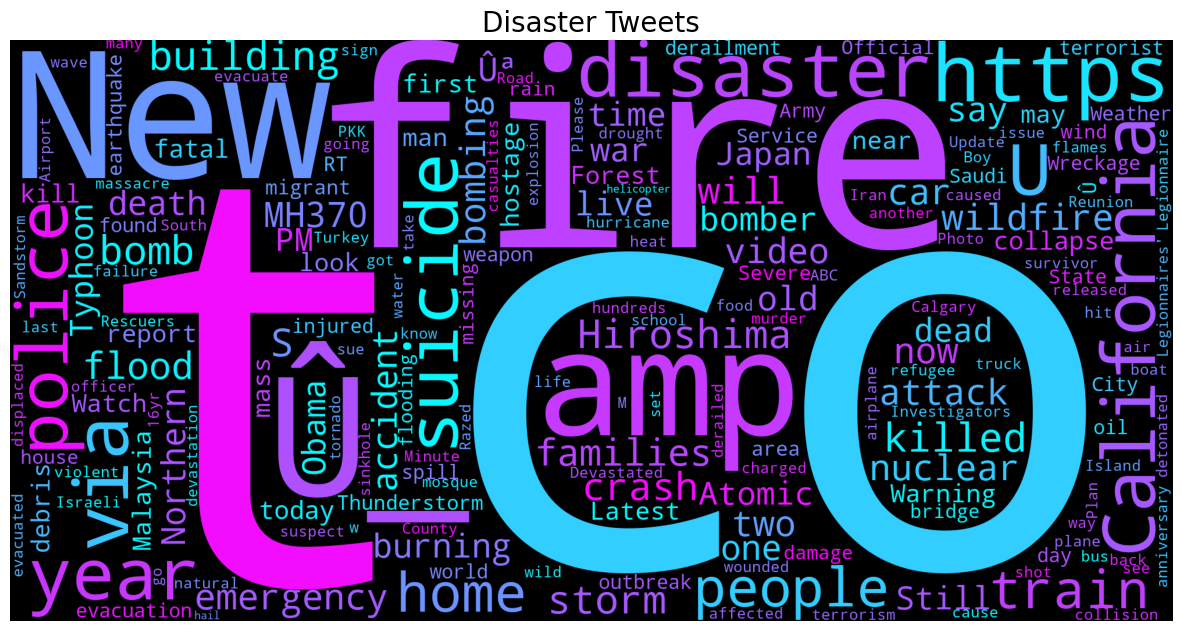

In [247]:
# Membuat wordcloud
text_disaster = eda[eda['target'] == 1].text.values
cloud_text_disaster = WordCloud(background_color='black',colormap="cool",collocations=False,width=2000,height=1000).generate(" ".join(text_disaster))

# Menampilkan wordcloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title("Disaster Tweets",fontsize=20)
plt.imshow(cloud_text_disaster)

In [248]:
#top 10 highest disaster tweets
disaster_tweets = eda[eda['target']==1]
high_disaster_tweets = Counter([item for sublist in disaster_tweets['tweet_list'] for item in sublist])
high_disaster_tweets = pd.DataFrame(high_disaster_tweets.most_common(10))
high_disaster_tweets.columns = ['Words','Count']
high_disaster_tweets

Words  Count
0   the   1051
1    in   1037
2    of    888
3     a    730
4    to    706
5   and    462
6     -    389
7    on    386
8   for    368
9    is    302

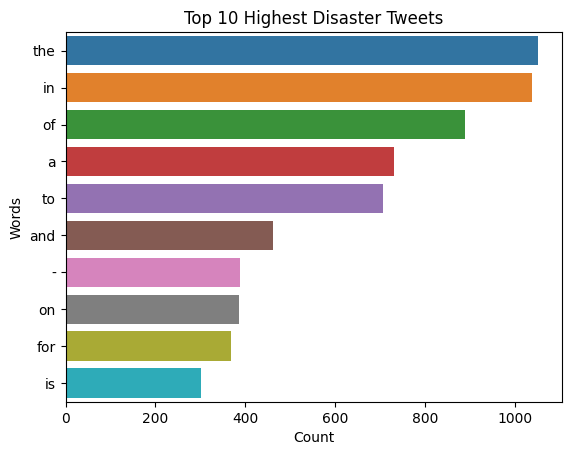

In [249]:
#show top 10 disaster tweets
sns.barplot(x='Count',y='Words',data=high_disaster_tweets)
plt.title('Top 10 Highest Disaster Tweets')
plt.show()

Insight :

1. Pada disaster tweets kata yang paling sering digunakan yaitu *Fire*,*CO*,*New*,*t*,*amp*
2. Dominan *lowercase*
3. Terdapat website karena ada kata **https**
4. Terdapat verb + ing  seperti *flooding*,*missing*,*warning*,*bombing*

**Wordcloud Non-Disaster Tweets**

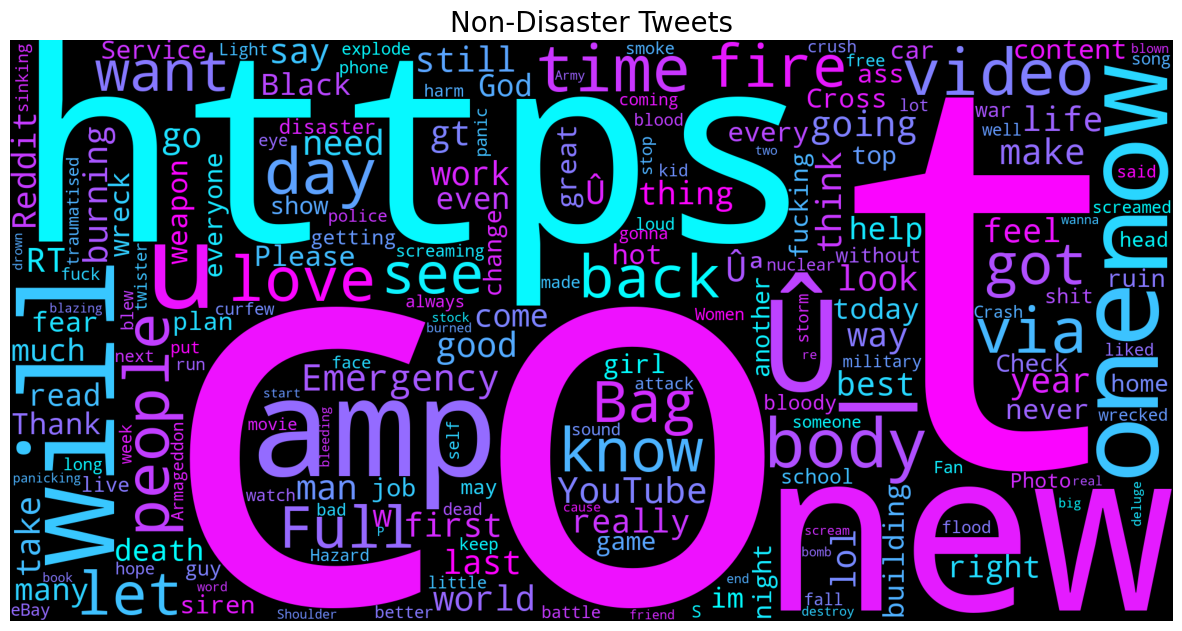

In [250]:
# Membuat wordcloud
text_non_disaster = eda[eda['target'] == 0].text.values
cloud_text_non_disaster = WordCloud(background_color='black',colormap="cool",collocations=False,width=2000,height=1000).generate(" ".join(text_non_disaster))

# Menampilkan wordcloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title("Non-Disaster Tweets",fontsize=20)
plt.imshow(cloud_text_non_disaster)

In [251]:
#top 10 highest non disaster tweets
non_disaster_tweets = eda[eda['target']==0]
high_non_disaster_tweets = Counter([item for sublist in non_disaster_tweets['tweet_list'] for item in sublist])
high_non_disaster_tweets = pd.DataFrame(high_non_disaster_tweets.most_common(10))
high_non_disaster_tweets.columns = ['Words','Count']
high_non_disaster_tweets

Words  Count
0   the   1524
1     a   1115
2    to   1099
3     I    938
4   and    840
5    of    834
6    in    720
7   you    529
8    is    512
9   for    452

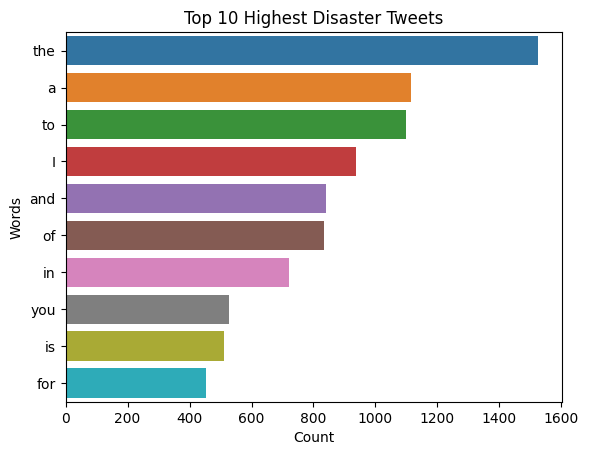

In [252]:
#show top 10 non disaster tweets
sns.barplot(x='Count',y='Words',data=high_non_disaster_tweets)
plt.title('Top 10 Highest Disaster Tweets')
plt.show()

Insight: 
1. Pada non disaster tweets kata terbanyak yang digunakan yaitu *new*,*co*,*t*,*will*,*https*,*amp*
2. Dominan menggunakan *lowercase*
3. Terdapat website karena ada **https**

# 5 - Feature Engineering

# 5.1 Handling Missing Values

In [253]:
df = df_train.copy()

In [254]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

base on my personal judgement, kolom location dan kolom id tidak terlalu berpengaruh apakah tweet tersebut disaster atau tidak, maka dari itu kolom location dan id akan saya drop.

untuk kolom keyword karena hanya 61 data akan saya isi dengan 'other'

In [255]:
#drop kolom location
df.drop(['location'],axis=1,inplace=True)

In [256]:
df.drop(['id'],axis=1,inplace=True)

In [257]:
df

keyword                                               text  target
0        NaN  Our Deeds are the Reason of this #earthquake M...       1
1        NaN             Forest fire near La Ronge Sask. Canada       1
2        NaN  All residents asked to 'shelter in place' are ...       1
3        NaN  13,000 people receive #wildfires evacuation or...       1
4        NaN  Just got sent this photo from Ruby #Alaska as ...       1
...      ...                                                ...     ...
7608     NaN  Two giant cranes holding a bridge collapse int...       1
7609     NaN  @aria_ahrary @TheTawniest The out of control w...       1
7610     NaN  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1
7611     NaN  Police investigating after an e-bike collided ...       1
7612     NaN  The Latest: More Homes Razed by Northern Calif...       1

[7613 rows x 3 columns]

In [258]:
df = df.fillna('other')

In [259]:
df.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

## 5.2 - Text Preprocessing

Berdasarkan Exploratory Data Analysis hal yang akan dilakukan : 

1. Convert ke lowercase

    Saya melakukan convert karena dominan text pada tweets menggunakan lowercase

2. Remove Website

    Saya melakukan remove website karena pada disaster maupun non disaster tweets, terdapat https yang menunjukkan sebuah website.

3. Stopwords
4. Remove emoticon maupun simbol matematika
5. Remove mention
6. Remove hashtag
7. Lemmatizer

    Dilakukan karena adanya tweets yang mengandung verb+ing 
8. Word Tokenizer

    Saya menggunakan word tokenizer karena kombinasi dari kalimat sangat banyak sekali, sehingga jika 1 kalimat dijadikan 1 token maka hasil model akan kurang akurat.

In [260]:
# Pembuatan stopwords english
new_stopwords = ['t','rt','co']
stopwords_eng = stopwords.words("english")
stopwords_eng = stopwords_eng + new_stopwords
stopwords_eng = list(set(stopwords_eng))

In [334]:
#pembuatan pemrosesan tweets
lemmatizer = WordNetLemmatizer()
def proses_tweets(tweets):
    tweets = tweets.lower() # Mengubah Teks ke Lowercase
    tweets = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', tweets) # Menghilangkan http
    tweets = re.sub("@[A-Za-z0-9_]+", " ", tweets)  # Menghilangkan mention
    tweets = re.sub("#[A-Za-z0-9_]+", " ", tweets) # Menghilangkan hashtag
    tweets = re.sub(r"\\n", " ",tweets) # Menghilangkan \n (enter)
    tweets = tweets.strip() # Menghilangkan whitespace
    tweets = re.sub("[^A-Za-z\s']", " ", tweets) # Menghilangkan emoji atau atau simbol matematika
    tweets = re.sub("\s\s+" , " ", tweets) # Menghilangkan double spasi
    tokens = word_tokenize(tweets) # Melakukan tokenize
    tweets = ' '.join([word for word in tokens if word not in stopwords_eng]) # Menghilangkan stopwords
    tweets = lemmatizer.lemmatize(tweets) # Melakukan lemmatize
    return tweets

In [335]:
#pengaplikasian terhadap tweets

df_preprocessing = df.copy()

In [336]:
df_preprocessing['tweet_preprocessing'] = df_preprocessing['text'].apply(lambda x: proses_tweets(x))

In [337]:
df_preprocessing

keyword                                               text  target  \
0      other  Our Deeds are the Reason of this #earthquake M...       1   
1      other             Forest fire near La Ronge Sask. Canada       1   
2      other  All residents asked to 'shelter in place' are ...       1   
3      other  13,000 people receive #wildfires evacuation or...       1   
4      other  Just got sent this photo from Ruby #Alaska as ...       1   
...      ...                                                ...     ...   
7608   other  Two giant cranes holding a bridge collapse int...       1   
7609   other  @aria_ahrary @TheTawniest The out of control w...       1   
7610   other  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611   other  Police investigating after an e-bike collided ...       1   
7612   other  The Latest: More Homes Razed by Northern Calif...       1   

                                    tweet_preprocessing  
0          deeds reason earthquake may allah forgive us  
1                 forest fire near la ronge sask canada  
2     residents asked shelter place notified officer...  
3     people receive wildfires evacuation orders cal...  
4     got sent photo ruby alaska smoke wildfires pou...  
...                                                 ...  
7608  two giant cranes holding bridge collapse nearb...  
7609  thetawniest control wild fires california even...  
7610                              utc km volcano hawaii  
7611  police investigating e bike collided car littl...  
7612  latest homes razed northern california wildfir...  

[7613 rows x 4 columns]

## 5.3 Split Train-test-val Set

Pada session ini akan dilakukan *split train-set, val-set, dan test-set*

saya akan menggunakan data **tweet_preprocessing** sebagai corpus dan **target** sebagai target pada df_preprocessing

dimana Train-val-set menggunakan 85% dari data dan test-set 15% dan kemudian train-val-set akan dilakukan split kembali dengan proporsi yang sama 85% dan val-set 15%, menggunakan stratify karena data tidak terlalu balanced

In [338]:
X = df_preprocessing['tweet_preprocessing']
y = df_preprocessing['target']

In [339]:
# Split between Train-Set, Val-Set, and Test-Set

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=42,stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size : ', X_val.shape)
print('Test Size : ', X_test.shape)

Train Size :  (5500,)
Val Size :  (971,)
Test Size :  (1142,)


## 5.4 CountVectorizer

Pada session ini akan dilakukan countvectorizer untuk convert string menjadi numerical

In [340]:
count_vect = CountVectorizer()

count_vect.fit(X_train)
X_train_vect = count_vect.transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)

X_train_vect

<5500x12183 sparse matrix of type '<class 'numpy.int64'>'
	with 47238 stored elements in Compressed Sparse Row format>

dari corpus terdapat **67,281,500 values dari (5500x12233)** tetapi hanya **47289 token yang merupakan non-zero (0.703%) dengan 12183 vocabularies**

In [341]:
total_vocab = len(count_vect.vocabulary_.keys())
max_length = max([len(i.split(" ")) for i in X_train])

In [342]:
print(total_vocab)
print(max_length)

12183
24


## 5.5 Pipeline

Pada pipeline, yang akan saya gunakan yaitu :

1. Batch(32)   

    Setelah membaca beberapa sumber terdapat bahwa batch(32) merupakan aturan praktis dan pilihan yang baik (https://www.baeldung.com/cs/learning-rate-batch-size#:~:text=The%20batch%20size%20affects%20some,and%20a%20good%20initial%20choice.)
2. prefetch 

    Agar Preparing dan Training bisa dilakukan bersamaan

In [370]:
#pipeline untuk train dan val
train_pipe = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_pipe = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32)

# 6 -  EDA (After preprocessing)

**Pembuatan kolom jumlah kata dan jumlah karakter pada setiap tweet yang sudah di preprocessing**

In [344]:
#check jumlah kata pada tweet_preprocessing
df_preprocessing['tweet_sentences_length'] = df_preprocessing['tweet_preprocessing'].apply(lambda x: len(nltk.word_tokenize(x)))

In [345]:
#check jumlah karakter pada setiap tweet setelah dilakukan preprocessing
df_preprocessing["tweet_length"] = df_preprocessing["tweet_preprocessing"].apply(len)

In [346]:
#check data
df_preprocessing

keyword                                               text  target  \
0      other  Our Deeds are the Reason of this #earthquake M...       1   
1      other             Forest fire near La Ronge Sask. Canada       1   
2      other  All residents asked to 'shelter in place' are ...       1   
3      other  13,000 people receive #wildfires evacuation or...       1   
4      other  Just got sent this photo from Ruby #Alaska as ...       1   
...      ...                                                ...     ...   
7608   other  Two giant cranes holding a bridge collapse int...       1   
7609   other  @aria_ahrary @TheTawniest The out of control w...       1   
7610   other  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1   
7611   other  Police investigating after an e-bike collided ...       1   
7612   other  The Latest: More Homes Razed by Northern Calif...       1   

                                    tweet_preprocessing  \
0          deeds reason earthquake may allah forgive us   
1                 forest fire near la ronge sask canada   
2     residents asked shelter place notified officer...   
3     people receive wildfires evacuation orders cal...   
4     got sent photo ruby alaska smoke wildfires pou...   
...                                                 ...   
7608  two giant cranes holding bridge collapse nearb...   
7609  thetawniest control wild fires california even...   
7610                              utc km volcano hawaii   
7611  police investigating e bike collided car littl...   
7612  latest homes razed northern california wildfir...   

      tweet_sentences_length  tweet_length  
0                          7            44  
1                          7            37  
2                         11            88  
3                          6            53  
4                          9            55  
...                      ...           ...  
7608                       8            53  
7609                      10            76  
7610                       4            21  
7611                      17           116  
7612                       8            56  

[7613 rows x 6 columns]

**Average,Max,Min tweet preprocessing**

In [347]:
print('Sebelum Preprocessing')
print('Rata-rata karakter pada tweet sebelum di preprocessing ' ,eda['tweet_length'].mean())
print('Max karakter pada tweet sebelum di preprocessing',eda['tweet_length'].max())
print('Min karakter pada tweet sebelum di preprocessing',eda['tweet_length'].min())

print('\nSetelah Preprocessing')
print('Rata-rata karakter pada tweet setelah di preprocessing ' ,df_preprocessing['tweet_length'].mean())
print('Max karakter pada tweet setelah di preprocessing',df_preprocessing['tweet_length'].max())
print('Min karakter pada tweet setelah di preprocessing',df_preprocessing['tweet_length'].min())

Sebelum Preprocessing
Rata-rata karakter pada tweet sebelum di preprocessing  101.03743596479706
Max karakter pada tweet sebelum di preprocessing 157
Min karakter pada tweet sebelum di preprocessing 7

Setelah Preprocessing
Rata-rata karakter pada tweet setelah di preprocessing  60.94653881518455
Max karakter pada tweet setelah di preprocessing 138
Min karakter pada tweet setelah di preprocessing 0


In [348]:
print('Sebelum Preprocessing')
print('Rata-rata karakter pada tweet sebelum di preprocessing ' ,eda['tweet_sentences_length'].mean())
print('Max karakter pada tweet sebelum di preprocessing',eda['tweet_sentences_length'].max())
print('Min karakter pada tweet sebelum di preprocessing',eda['tweet_sentences_length'].min())

print('\nSetelah Preprocessing')
print('Rata-rata kata pada tweet setelah di preprocessing ' ,df_preprocessing['tweet_sentences_length'].mean())
print('Max kata pada tweet setelah di preprocessing',df_preprocessing['tweet_sentences_length'].max())
print('Min kata pada tweet setelah di preprocessing',df_preprocessing['tweet_sentences_length'].min())

Sebelum Preprocessing
Rata-rata karakter pada tweet sebelum di preprocessing  18.916327334822014
Max karakter pada tweet sebelum di preprocessing 72
Min karakter pada tweet sebelum di preprocessing 1

Setelah Preprocessing
Rata-rata kata pada tweet setelah di preprocessing  8.931827137790622
Max kata pada tweet setelah di preprocessing 24
Min kata pada tweet setelah di preprocessing 0


Insight : 

1. Dari data diatas diketahui bahwa rata-rata karakter pada tweet setelah preprocessing berkurang dari sebelumnya rata-rata 101 karakter per tweet menjadi 60 karakter per tweet (berkurang sebesar 40%)
2. Rata-rata kata pada tweet setelah preprocessing juga berkurang dari yang sebelumnya berata-rata di 19 kata per tweet menjadi 9 kata per tweet (berkurang sebesar 58%)
3. Maximum karakter pada tweet setelah preprocessing juga berkurang,  yang sebelumnya 157 menjadi 138
4. Maximum kata pada tweet setelah preprocessing juga berkurang, dari yang sebelumnya 72 kata menjadi 24 kata per tweet
5. Minimum karakter pada tweet setelah preprocessing berkurang,  yang sebelumnya 7 karakter per tweet menjadi 0 karakter
6. Minimum kata pada tweet setelah preprocessing berkurang, yang sebelumnya 1 kata menjadi 0 kata per tweet.

**Average,Max,Min pada disaster/non disaster class**

In [349]:
#check max kata pada setiap disaster tweets sebelum dan sesudah preprocessing
print('Sebelum di preprocessing')
print('Rata-rata kata pada tweet disaster sebelum di preprocessing ' ,eda[eda['target'] == 1]['tweet_sentences_length'].mean())
print('Max kata pada tweet disaster sebelum di preprocessing ' ,eda[eda['target'] == 1]['tweet_sentences_length'].max())
print('Min kata pada tweet disaster sebelum di preprocessing ' ,eda[eda['target'] == 1]['tweet_sentences_length'].min())
print('\nSetelah di preprocessing')
print('Rata-rata kata pada tweet disaster setelah di preprocessing ' ,df_preprocessing[df_preprocessing['target'] == 1]['tweet_sentences_length'].mean())
print('Max kata pada tweet disaster setelah di preprocessing ' ,df_preprocessing[df_preprocessing['target'] == 1]['tweet_sentences_length'].max())
print('Min kata pada tweet disaster setelah di preprocessing ' ,df_preprocessing[df_preprocessing['target'] == 1]['tweet_sentences_length'].min())


Sebelum di preprocessing
Rata-rata kata pada tweet disaster sebelum di preprocessing  19.256802201161726
Max kata pada tweet disaster sebelum di preprocessing  39
Min kata pada tweet disaster sebelum di preprocessing  2

Setelah di preprocessing
Rata-rata kata pada tweet disaster setelah di preprocessing  9.501987159889941
Max kata pada tweet disaster setelah di preprocessing  24
Min kata pada tweet disaster setelah di preprocessing  0


In [350]:
#check max kata pada setiap disaster tweets sebelum dan sesudah preprocessing
print('Sebelum di preprocessing')
print('Rata-rata karakter pada tweet non disaster sebelum di preprocessing ' ,eda[eda['target'] == 0]['tweet_sentences_length'].mean())
print('Max karakter pada tweet non disaster sebelum di preprocessing ' ,eda[eda['target'] == 0]['tweet_sentences_length'].max())
print('Min karakter pada tweet non disaster sebelum di preprocessing ' ,eda[eda['target'] == 0]['tweet_sentences_length'].min())
print('\nSetelah di preprocessing')
print('Rata-rata kata pada tweet non disaster setelah di preprocessing ' ,df_preprocessing[df_preprocessing['target'] == 0]['tweet_sentences_length'].mean())
print('Max kata pada tweet non disaster setelah di preprocessing ' ,df_preprocessing[df_preprocessing['target'] == 0]['tweet_sentences_length'].max())
print('Min kata pada tweet non disaster setelah di preprocessing ' ,df_preprocessing[df_preprocessing['target'] == 0]['tweet_sentences_length'].min())


Sebelum di preprocessing
Rata-rata karakter pada tweet non disaster sebelum di preprocessing  18.65983417779825
Max karakter pada tweet non disaster sebelum di preprocessing  72
Min karakter pada tweet non disaster sebelum di preprocessing  1

Setelah di preprocessing
Rata-rata kata pada tweet non disaster setelah di preprocessing  8.502303086135422
Max kata pada tweet non disaster setelah di preprocessing  23
Min kata pada tweet non disaster setelah di preprocessing  0


Insight :

setelah dilakukan preprocessing dapat diketahui bahwa :

1. Rata-rata di disaster maupun non disaster terdapat pengurangan yang lumayan besar sekitar 50%
2. Maximum kata pada tweet disaster mengalami pengurangan yang sebelumnya 39 menjadi 24
3. Maximum kata pada tweet non disaster mengalami pengurangan yang besar yang sebelumnya 72 kata menjadi 23 kata (67%) pengurangan kata.
4. Minimum kata pada disaster tidak mengalami penurunan yang terlalu signifikan, bisa dilihat bahwa pada disaster yang sebelumnya 2 kata menjadi 0 kata
5. Minimum kata pada non-disaster mengalami penurunan dari 1 kata menjadi 0 kata.

**WordCloud Tweet Preprocessing**

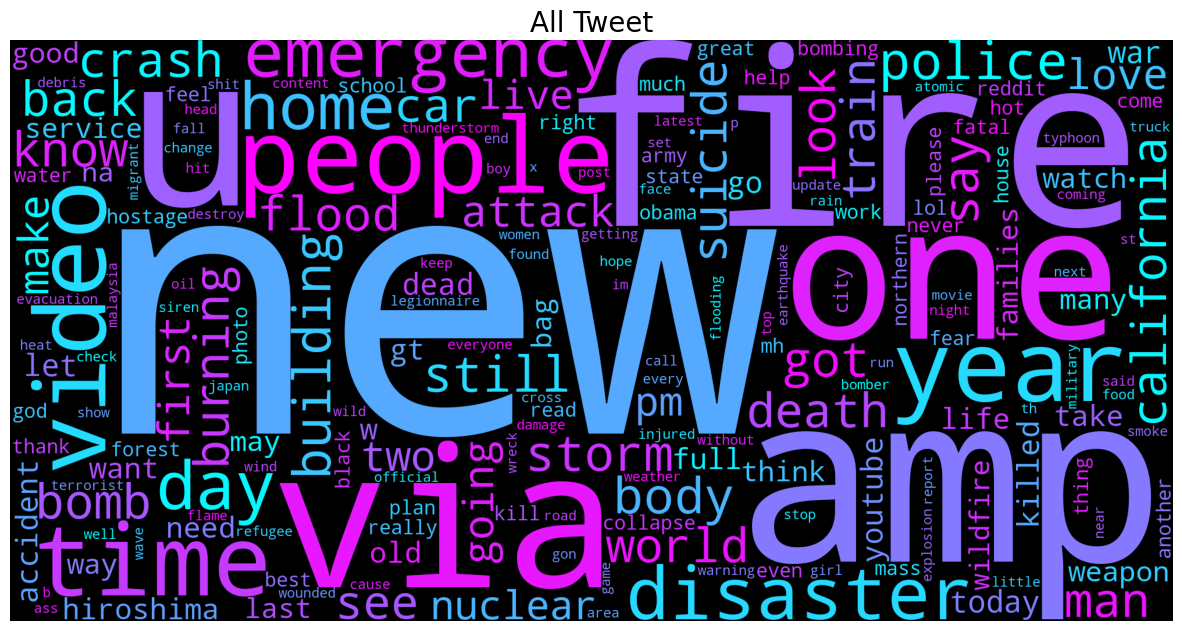

In [351]:
#membuat wordcloud
tweets_text_preprocessing = df_preprocessing.tweet_preprocessing.values
cloud_text_preprocessing = WordCloud(background_color='black',colormap="cool",collocations=False,width=2000,height=1000).generate(" ".join(tweets_text_preprocessing))


# Menampilkan wordcloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title("All Tweet",fontsize=20)
plt.imshow(cloud_text_preprocessing)

Insight : 

1. Kata yang sering digunakan masih sama seperti preprocessing
2. Sudah tidak ada website link (https)
3. Verb+ing sudah mul i berkurang namun masih ada beberapa seperti bombing,getting

**WordCloud Disaster Tweet Preprocessing**

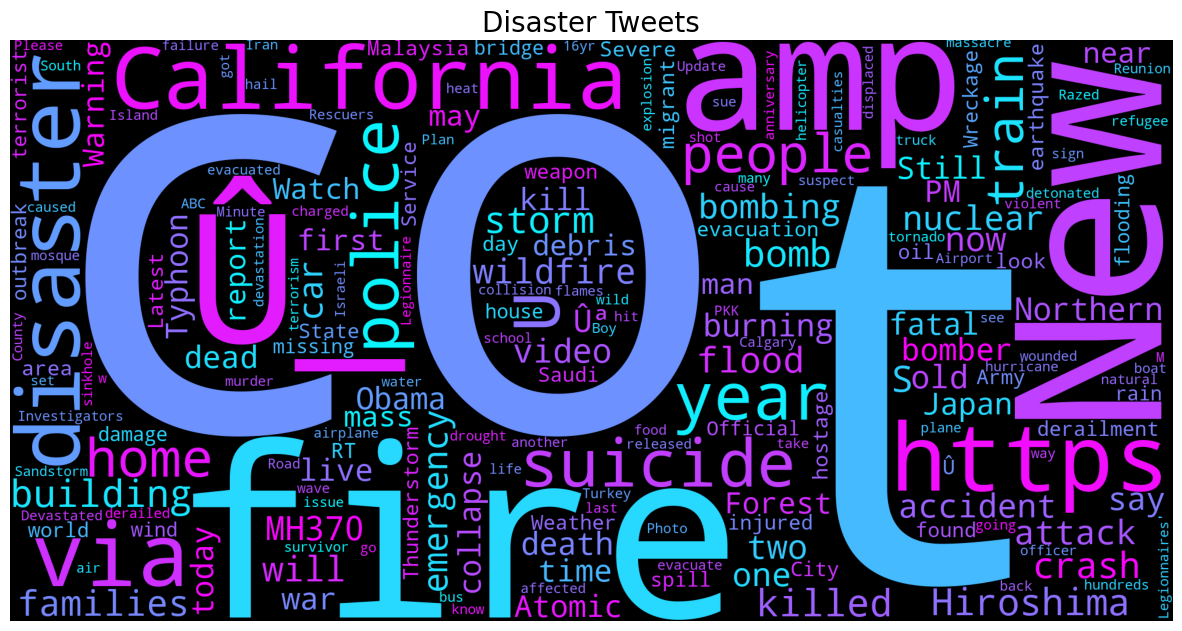

In [352]:
# Membuat wordcloud
text_disaster_preprocessing = df_preprocessing[df_preprocessing['target'] == 1].text.values
cloud_text_disaster_preprocessing = WordCloud(background_color='black',colormap="cool",collocations=False,width=2000,height=1000).generate(" ".join(text_disaster_preprocessing))

# Menampilkan wordcloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title("Disaster Tweets",fontsize=20)
plt.imshow(cloud_text_disaster_preprocessing)

Insight :

1. Kata yang masih sering digunakan masih sama dengan sebelum preprocessing
2. Masih ada website(https)
3. Verb+ing sudah mulai berkurang, namun masih ada yang tertinggal seperti burning,warning

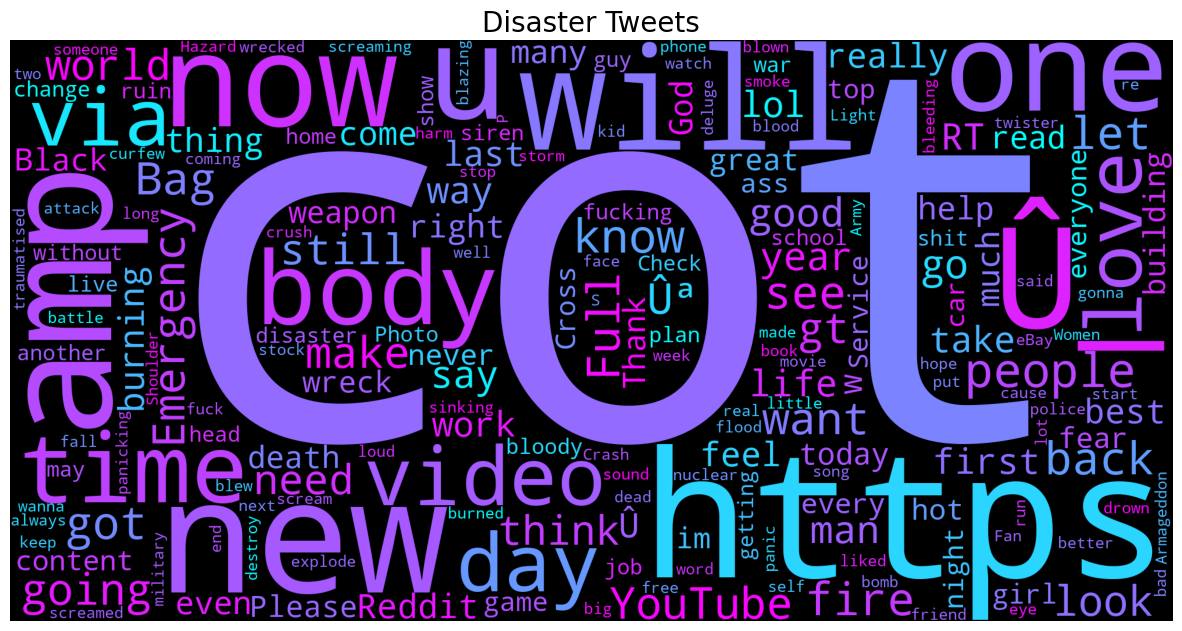

In [353]:
# Membuat wordcloud
text_non_disaster_preprocessing = df_preprocessing[df_preprocessing['target'] == 0].text.values
cloud_text_non_disaster_preprocessing = WordCloud(background_color='black',colormap="cool",collocations=False,width=2000,height=1000).generate(" ".join(text_non_disaster_preprocessing))

# Menampilkan wordcloud
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title("Disaster Tweets",fontsize=20)
plt.imshow(cloud_text_non_disaster_preprocessing)

Insight :

1. Kata yang masih sering digunakan masih sama dengan sebelum preprocessing
2. Masih ada https (sudah mencoba untuk menghilangkan melalui beberapa source namun tetap ada)
3. Verb+ing sudah mulai berkurang, namun masih ada yang tertinggal seperti going,building

# 7 - Model Definition

Pada permodelan ini akan digunakan algoritma LSTM dan GRU , setiap model akan dilakukan 2x permodelan (improvement dan tidak) maka total permodelan akan ada 4 model

Alasan memakai LSTM dan GRU : 

LSTM :

Kelebihan : 

- Model LSTM sangat cocok untuk digunakan pada data text

- Kemampuannya untuk mempelajari ketergantungan jangka panjang dan menangkap pola yang kompleks pada data yang berurutan.
(https://www.linkedin.com/advice/1/what-advantages-disadvantages-using-long-short-term)

Kekurangan : 
- Model LSTM bisa sangat lama untuk train dengan data yang besar, tetapi data yang saya gunakan tidak terlalu besar (7700 data) (https://www.knowledgehut.com/blog/web-development/long-short-term-memory#:~:text=First%2C%20they%20are%20more%20complicated,to%20train%20on%20large%20datasets.)

GRU : 

Kelebihan :
- Memiliki waktu training yang lebih cepat dibanding LSTM

Kekurangan :
- Terlalu complex dan susah untuk train
- Memiliki resiko tinggi untuk over-fit
(https://www.linkedin.com/advice/1/what-advantages-challenges-using-lstm-gru-long-term#:~:text=The%20main%20challenges%20with%20LSTM,risk%20of%20overfitting%20the%20data.)

Metrics yang akan digunakan yaitu accuracy dan roc-auc score 

accuracy digunakan karena data sudah lumayan balanced. 

**Acceptable score** yang akan digunakan yaitu 70%


# 8 - Model LSTM Before Improvement (Training,Evaluation)

## 8.1 - Model Training

Pada training kali ini akan digunakan Sequential API , optimizer adam , dan 4 hidden layer

hidden layer pertama akan bernilai 128
hidden layer kedua akan bernilai 64
hidden layer ketiga akan bernilai 32
hidden layer keempat akan bernilai 16

In [354]:
# Clear Session

seed = 50
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [355]:
# Text Vectorization Layer

tweet_vectorization = TextVectorization(max_tokens=total_vocab, #jumlah token = total vocab
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None, # agar inisialisasi 0 , untuk melihat apakah butuh menambahkan augmentasi atau tidak
                                       output_mode="int",
                                       output_sequence_length=max_length,
                                       input_shape=(1,)
                                       )

tweet_vectorization.adapt(X_train)

In [374]:
# Embedding Layer

embedding_basemodel = Embedding(input_dim=total_vocab,
                      output_dim=128, #karena jumlah vocab yang besar
                      embeddings_initializer="uniform",
                      input_length=max_length
                      )

In [389]:
# Melihat Top 10 Token (Diurutkan Berdasarkan Frekuensi Kemunculan Terbesar)

tweet_vectorization.get_vocabulary()[:10]

['', '[UNK]', 'like', 'amp', 'fire', 'new', 'via', 'news', 'get', 'people']

Insight :

kata *'amp','like','fire'* merupakan 3 kata yang paling sering muncul

In [420]:
#pembuatan model
sequential = Sequential()

# Layer Text Vectorization
sequential.add(tweet_vectorization)

# Layer Embedding
sequential.add(embedding_basemodel)

# Hidden Layer 1
sequential.add(LSTM(128, return_sequences=True))

# Hidden Layer 2
sequential.add(LSTM(64, return_sequences=True))

# Hidden Layer 3
sequential.add(LSTM(32, return_sequences=True))

# Hidden Layer 4
sequential.add(LSTM(16, return_sequences=False))

# Layer Output
sequential.add(Dense(1,activation='sigmoid'))

# Compile
sequential.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Summary
sequential.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 24, 128)           1559424   
                                                                 
 lstm_56 (LSTM)              (None, 24, 128)           131584    
                                                                 
 lstm_57 (LSTM)              (None, 24, 64)            49408     
                                                                 
 lstm_58 (LSTM)              (None, 24, 32)            12416     
                                                                 
 lstm_59 (LSTM)              (None, 16)                3136      
                                                     

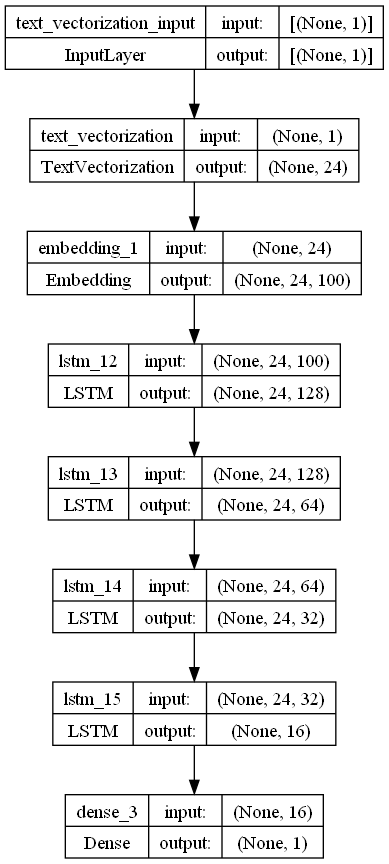

In [377]:
# Plot Layers
tf.keras.utils.plot_model(sequential, show_shapes=True)

Saya akan melakukan 10 epoch untuk model ini karena mengingat komputer saya yang tidak terlalu cepat untuk melakukan epoch yang terlalu banyak

In [421]:
# Train the Model
model_sequential = sequential.fit(train_pipe, epochs=10, validation_data=val_pipe)

Epoch 1/10
172/172 [==============================] - 38s 117ms/step - loss: 0.1169 - accuracy: 0.9749 - val_loss: 0.8389 - val_accuracy: 0.7765
Epoch 2/10
172/172 [==============================] - 17s 97ms/step - loss: 0.0469 - accuracy: 0.9818 - val_loss: 1.3099 - val_accuracy: 0.7384
Epoch 3/10
172/172 [==============================] - 17s 100ms/step - loss: 0.0456 - accuracy: 0.9802 - val_loss: 1.2783 - val_accuracy: 0.7631
Epoch 4/10
172/172 [==============================] - 16s 95ms/step - loss: 0.0427 - accuracy: 0.9815 - val_loss: 1.3420 - val_accuracy: 0.7611
Epoch 5/10
172/172 [==============================] - 16s 91ms/step - loss: 0.0422 - accuracy: 0.9827 - val_loss: 1.1308 - val_accuracy: 0.7621
Epoch 6/10
172/172 [==============================] - 16s 91ms/step - loss: 0.0504 - accuracy: 0.9802 - val_loss: 1.3585 - val_accuracy: 0.7642
Epoch 7/10
172/172 [==============================] - 17s 96ms/step - loss: 0.0433 - accuracy: 0.9818 - val_loss: 1.1375 - val_accurac

## 8.2 - Model Evaluation

In [422]:
# Create DataFrame

history_seq_df = pd.DataFrame(model_sequential.history)
history_seq_df

loss  accuracy  val_loss  val_accuracy
0  0.116899  0.974909  0.838941      0.776519
1  0.046943  0.981818  1.309947      0.738414
2  0.045596  0.980182  1.278299      0.763131
3  0.042729  0.981455  1.341992      0.761071
4  0.042200  0.982727  1.130823      0.762101
5  0.050385  0.980182  1.358526      0.764161
6  0.043323  0.981818  1.137504      0.777549
7  0.037538  0.981636  1.359429      0.765191
8  0.044002  0.983091  1.065479      0.763131
9  0.036754  0.984364  1.455458      0.759011

<Axes: >

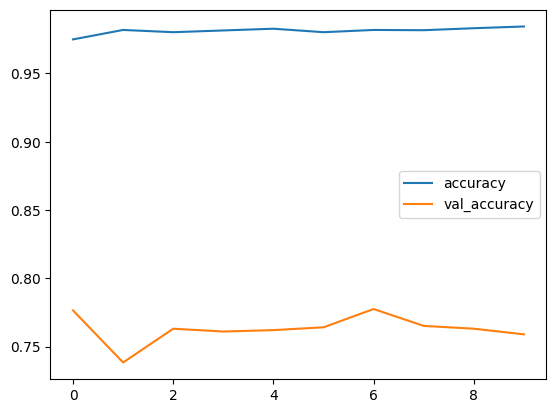

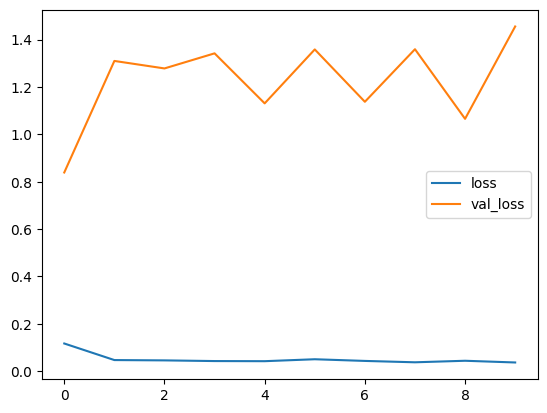

In [423]:
# Plot training results
history_seq_df[['accuracy','val_accuracy']].plot()
history_seq_df[['loss','val_loss']].plot()

Insight : 

1. Accuracy pada train data cenderung sangat besar yaitu 98% sedangkan pada val-set hanya 76%
2. loss pada train-set cenderung kecil namun pada val-set cenderung sangat tinggi  dan tidak stabil (naik turun) , model ini belum menemukan titik konvergensi dan cenderung sangat over-fit

In [428]:
#classificati report terhadap X_test
y_pred_seq = sequential.predict(X_test)
y_pred_seq = np.where(y_pred_seq >= 0.5,1,0)

print(classification_report(y_test,y_pred_seq))

36/36 [==============================] - 1s 29ms/step
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       651
           1       0.71      0.67      0.69       491

    accuracy                           0.74      1142
   macro avg       0.73      0.73      0.73      1142
weighted avg       0.74      0.74      0.74      1142



Insight : 

- model memiliki nilai classification diatas 70% pada class non disaster (0) yang artinya masih ada 30% data yang terprediksi sebagai false negative.
- model memiliki nilai classification diantara 67-71% pada class disaster(1) yang artinya masih ada sekitar 30% data yang terprediksi sebagai false positive.
- accuracy pada model sudah bagus yaitu berada di 74% 

## 8.3 - Model Analysis

In [482]:
#pembuatan analysis terhadap prediksi dan nilai asli
analysis = pd.DataFrame({'nilai_asli': y_test,'prediksi': np.ndarray.flatten(y_pred_seq)})
df_analysis = pd.concat([pd.DataFrame(X_test), analysis],axis=1)

df_analysis

tweet_preprocessing  nilai_asli  prediksi
1182  australia ashes disaster collapse unfolded tre...           1         1
7515           malaysia pm confirms wreckage belongs mh           1         1
1294                        burned shit outta dirt bike           0         0
6551                  grace god survived shift im tired           0         1
2702   new favorite trivium detonation rrusa soundcloud           0         0
...                                                 ...         ...       ...
1748  motorcyclist bicyclist injured denver collisio...           1         1
1541  google alert emergency units simulate chemical...           0         1
1946                   da judge gave dis girl pm curfew           0         0
6124                        time try always end sinking           0         0
6429  grogparty tony burke lessons suicide bombing imam           1         1

[1142 rows x 3 columns]

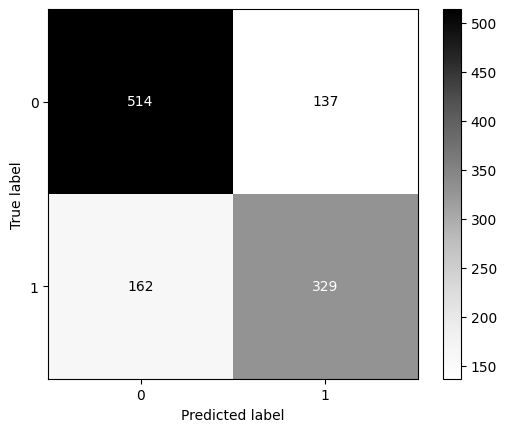

In [429]:
#confussion matrix
cm = confusion_matrix(y_test, y_pred_seq)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp.plot(cmap='Greys')
plt.show()

Insight :

Model cenderung masih salah memprediksi pada class target disaster maupun non disaster, jika dilihat pada classification_report didapatkan bahwa ada setidaknya 30% data yang diprediksi salah.

# 9 - Model LSTM (Improvement)

## 9.1 - Model Training

Pada improvement kali ini akan digunakan

1. Bidirectional agar model bisa belajar dua arah (connect terhadap sesama hidden layer)
2. Hidden layer yang digunakan akan tetap sama
3. metrics dan optimizer yang digunakan akan tetap sama 

In [430]:
# Penyusunan Model
model_sequential1 = Sequential()

# Layer Text Vectorization
model_sequential1.add(tweet_vectorization)
# Layer Embedding
model_sequential1.add(embedding_basemodel)
# Hidden Layer 1
model_sequential1.add(tf.keras.layers.Bidirectional(LSTM(128,return_sequences=True)))
# Hidden Layer 2
model_sequential1.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
# Hidden Layer 3
model_sequential1.add(tf.keras.layers.Bidirectional(LSTM(32,return_sequences=True)))

# Hidden Layer 4
model_sequential1.add(tf.keras.layers.Bidirectional(LSTM(16)))

# Layer Output
model_sequential1.add(Dense(1,activation='sigmoid'))

# Compile
model_sequential1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Summary
model_sequential1.summary()



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 24, 128)           1559424   
                                                                 
 bidirectional_12 (Bidirecti  (None, 24, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 24, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_14 (Bidirecti  (None, 24, 64)           41216     
 onal)                                               

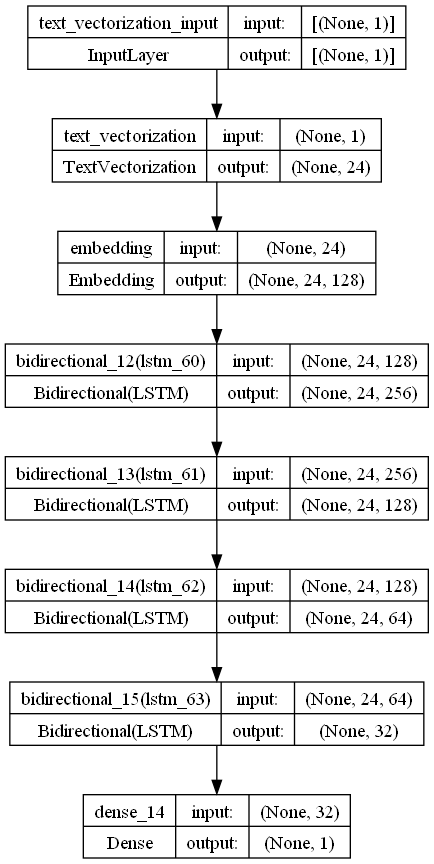

In [431]:
# Plot Layers
tf.keras.utils.plot_model(model_sequential1, show_shapes=True)

In [432]:
# train the model
model_seq_improve = model_sequential1.fit(train_pipe, epochs=10, validation_data=val_pipe)

Epoch 1/10
172/172 [==============================] - 65s 177ms/step - loss: 0.0814 - accuracy: 0.9722 - val_loss: 1.1935 - val_accuracy: 0.7724
Epoch 2/10
172/172 [==============================] - 23s 136ms/step - loss: 0.0379 - accuracy: 0.9824 - val_loss: 1.1047 - val_accuracy: 0.7611
Epoch 3/10
172/172 [==============================] - 24s 137ms/step - loss: 0.0411 - accuracy: 0.9813 - val_loss: 1.0170 - val_accuracy: 0.7765
Epoch 4/10
172/172 [==============================] - 24s 137ms/step - loss: 0.0377 - accuracy: 0.9844 - val_loss: 1.3597 - val_accuracy: 0.7724
Epoch 5/10
172/172 [==============================] - 24s 137ms/step - loss: 0.0344 - accuracy: 0.9840 - val_loss: 1.4859 - val_accuracy: 0.7662
Epoch 6/10
172/172 [==============================] - 24s 136ms/step - loss: 0.0319 - accuracy: 0.9831 - val_loss: 1.4331 - val_accuracy: 0.7724
Epoch 7/10
172/172 [==============================] - 24s 136ms/step - loss: 0.0303 - accuracy: 0.9836 - val_loss: 1.5852 - val_ac

## 9.2 - Model Evaluation

In [433]:
# Create DataFrame

history_seq1_df = pd.DataFrame(model_seq_improve.history)
history_seq1_df

loss  accuracy  val_loss  val_accuracy
0  0.081388  0.972182  1.193491      0.772400
1  0.037856  0.982364  1.104737      0.761071
2  0.041136  0.981273  1.017049      0.776519
3  0.037747  0.984364  1.359705      0.772400
4  0.034375  0.984000  1.485898      0.766220
5  0.031917  0.983091  1.433115      0.772400
6  0.030333  0.983636  1.585151      0.768280
7  0.030481  0.984000  1.631227      0.770340
8  0.033163  0.982727  1.498448      0.774459
9  0.033077  0.982727  1.447603      0.773429

<Axes: >

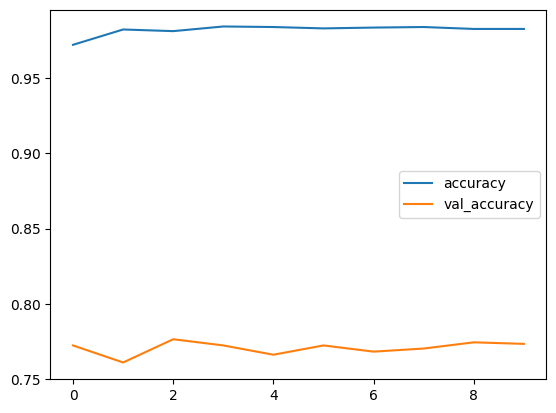

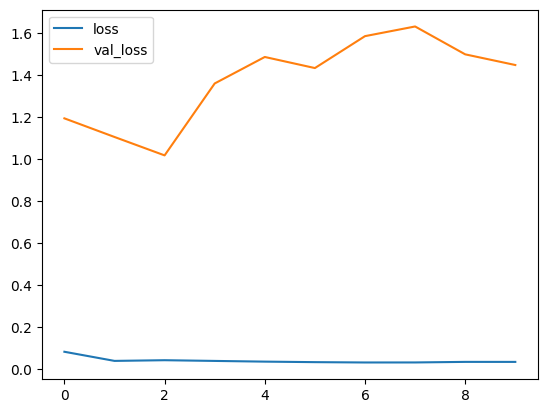

In [434]:
# Plot training results
history_seq1_df[['accuracy','val_accuracy']].plot()
history_seq1_df[['loss','val_loss']].plot()

In [435]:
#classificati report terhadap X_test
y_pred_seq1 = model_sequential1.predict(X_test)
y_pred_seq1 = np.where(y_pred_seq1 >= 0.5,1,0)

print(classification_report(y_test,y_pred_seq1))

36/36 [==============================] - 8s 41ms/step
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       651
           1       0.81      0.56      0.66       491

    accuracy                           0.75      1142
   macro avg       0.77      0.73      0.74      1142
weighted avg       0.77      0.75      0.75      1142



Insight : 

- model memiliki nilai recall yang sangat tinggi di 90% pada class non disaster (0) yang artinya hanya sedikit yang terprediksi sebagai false negative
- model memiliki nilai recall di 56% pada class disaster(1) yang artinya ada sekitar 44% data yang terdepriksi sebagai non disaster class namun pada precission mengamali peningkatan yang sangat tinggi yang sebelumnya 0.71 menjadi 0.81 ini membuktikan bahwa  tentang seberapa akurat model dalam mengidentifikasi class true possitive
- accuracy pada model berada pada angka 75% yang artinya model sudah memprediksi lumayan dari sebelumnya 74% (mengalami kenaikan 1%)

## 9.3 Model Analysis

In [483]:
#pembuatan analysis terhadap prediksi dan nilai asli
analysis1 = pd.DataFrame({'nilai_asli': y_test,'prediksi': np.ndarray.flatten(y_pred_seq1)})
df_analysis_improvement = pd.concat([pd.DataFrame(X_test), analysis1],axis=1)

df_analysis_improvement

tweet_preprocessing  nilai_asli  prediksi
1182  australia ashes disaster collapse unfolded tre...           1         1
7515           malaysia pm confirms wreckage belongs mh           1         1
1294                        burned shit outta dirt bike           0         0
6551                  grace god survived shift im tired           0         1
2702   new favorite trivium detonation rrusa soundcloud           0         0
...                                                 ...         ...       ...
1748  motorcyclist bicyclist injured denver collisio...           1         1
1541  google alert emergency units simulate chemical...           0         1
1946                   da judge gave dis girl pm curfew           0         0
6124                        time try always end sinking           0         0
6429  grogparty tony burke lessons suicide bombing imam           1         0

[1142 rows x 3 columns]

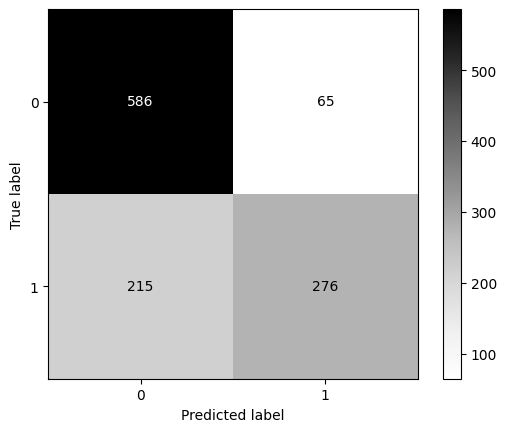

In [438]:
#confussion matrix
cm = confusion_matrix(y_test, y_pred_seq1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp1.plot(cmap='Greys')
plt.show()

Insight :

Model cenderung masih salah memprediksi pada class target disaster maupun non disaster, jika dilihat pada classification_report didapatkan bahwa ada setidaknya 44% data pada disaster class yang diprediksi salah, sedangkan pada data non disaster ada sekitar 10% data yang terprediksi salah(sudah baik)

# 10 Model GRU Before Improvement

## 10.1 - Model Training

Pada training kali ini yang digunakan tidak akan jauh berbeda dengan LSTM Model
Sequential API , optimizer adam , dan 4 hidden layer

hidden layer pertama akan bernilai 128
hidden layer kedua akan bernilai 64
hidden layer ketiga akan bernilai 32
hidden layer keempat akan bernilai 16

menggunakan GRU karena waktu training lebih cepat dibandingkan dengan LSTM dan akan menggunakan output_dim sebanyak 32

In [457]:
# Clear Session

seed = 50
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [456]:
#pembuatan model
model_sequential2 = Sequential()

# Layer Text Vectorization
model_sequential2.add(tweet_vectorization)

# Layer Embedding
model_sequential2.add(embedding_basemodel)

# Hidden Layer 1
model_sequential2.add(GRU(128, return_sequences=True))

# Hidden Layer 2
model_sequential2.add(GRU(64, return_sequences=True))

# Hidden Layer 3
model_sequential2.add(GRU(32, return_sequences=True))

# Hidden Layer 4
model_sequential2.add(GRU(16, return_sequences=False))

# Layer Output
model_sequential2.add(Dense(1,activation='sigmoid'))

# Compile
model_sequential2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Summary
model_sequential2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 24, 128)           1559424   
                                                                 
 gru_23 (GRU)                (None, 24, 128)           99072     
                                                                 
 gru_24 (GRU)                (None, 24, 64)            37248     
                                                                 
 gru_25 (GRU)                (None, 24, 32)            9408      
                                                                 
 gru_26 (GRU)                (None, 16)                2400      
                                                      

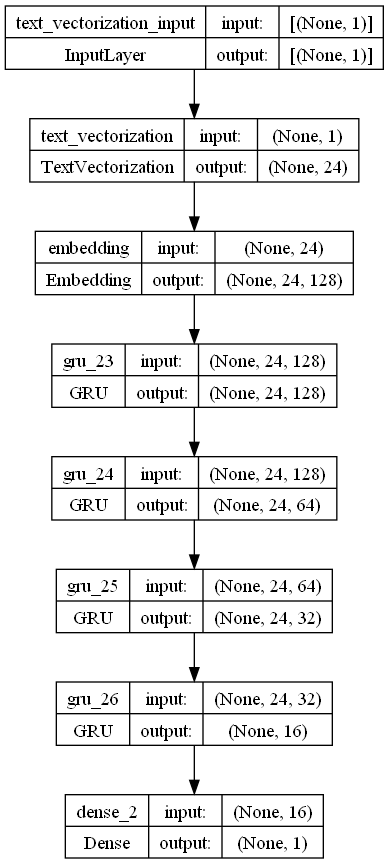

In [460]:
# Plot Layers
tf.keras.utils.plot_model(model_sequential2, show_shapes=True)

In [461]:
model_sequential_gru = model_sequential2.fit(train_pipe,epochs=10,validation_data = val_pipe)

Epoch 1/10
172/172 [==============================] - 34s 106ms/step - loss: 0.1333 - accuracy: 0.9529 - val_loss: 0.9121 - val_accuracy: 0.7817
Epoch 2/10
172/172 [==============================] - 15s 88ms/step - loss: 0.0490 - accuracy: 0.9816 - val_loss: 1.1321 - val_accuracy: 0.7786
Epoch 3/10
172/172 [==============================] - 15s 89ms/step - loss: 0.0664 - accuracy: 0.9765 - val_loss: 1.0288 - val_accuracy: 0.7621
Epoch 4/10
172/172 [==============================] - 16s 91ms/step - loss: 0.0601 - accuracy: 0.9798 - val_loss: 1.0977 - val_accuracy: 0.7827
Epoch 5/10
172/172 [==============================] - 15s 88ms/step - loss: 0.0431 - accuracy: 0.9818 - val_loss: 1.0936 - val_accuracy: 0.7714
Epoch 6/10
172/172 [==============================] - 15s 89ms/step - loss: 0.0343 - accuracy: 0.9836 - val_loss: 1.1625 - val_accuracy: 0.7662
Epoch 7/10
172/172 [==============================] - 15s 89ms/step - loss: 0.0446 - accuracy: 0.9818 - val_loss: 1.0667 - val_accuracy

## 10.2 - Model Evaluation

In [463]:
# Create DataFrame

history_seq2_df = pd.DataFrame(model_sequential_gru.history)
history_seq2_df

loss  accuracy  val_loss  val_accuracy
0  0.133271  0.952909  0.912068      0.781668
1  0.048984  0.981636  1.132115      0.778579
2  0.066421  0.976545  1.028765      0.762101
3  0.060142  0.979818  1.097705      0.782698
4  0.043097  0.981818  1.093632      0.771370
5  0.034274  0.983636  1.162525      0.766220
6  0.044577  0.981818  1.066732      0.782698
7  0.036037  0.983636  1.126387      0.775489
8  0.033158  0.984182  1.247543      0.772400
9  0.030967  0.985636  1.345142      0.774459

<Axes: >

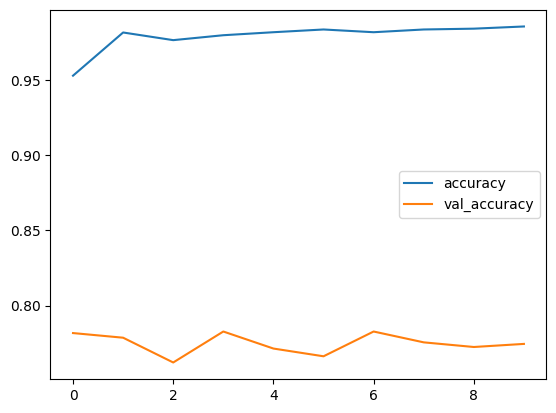

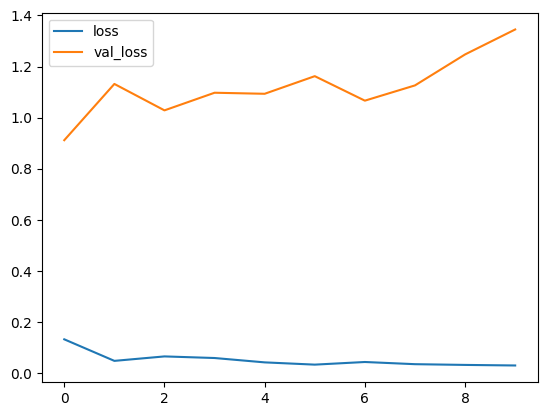

In [464]:
# Plot training results
history_seq2_df[['accuracy','val_accuracy']].plot()
history_seq2_df[['loss','val_loss']].plot()

In [465]:
#classificati report terhadap X_test
y_pred_seq2 = model_sequential2.predict(X_test)
y_pred_seq2 = np.where(y_pred_seq2 >= 0.5,1,0)

print(classification_report(y_test,y_pred_seq2))

36/36 [==============================] - 4s 22ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       651
           1       0.73      0.68      0.70       491

    accuracy                           0.75      1142
   macro avg       0.75      0.74      0.74      1142
weighted avg       0.75      0.75      0.75      1142



Insight :

1. Nilai acuracy pada data train sangatlah tinggi yaitu 98% sedangkan nilai acuracy pada data val tidak terlalu tinggi hanya 77% namun untuk prediksi ini nilai tersebut sudah baik
2. Dapat dilihat bahwa loss pada data val sangatlah tinggi dan diakhir epoch (antara 7-10) terus naik, maka bisa dibilang bahwa loss pada data val sangatlah buruk
3. Loss pada data train sangatlah baik terus menurun hingga 0.03, namun jika dilihat pada data ini sangatlah overfit.
4. Terlihat bahwa nilai classification report pada class 0 (non disaster) memiliki nilai yang cukup memuaskan yaitu diantar 77-81% sedangkan untuk class 1 (disaster) masih memiliki nilai yang kurang memuaskan yaitu 68-73%
5. Accuracy pada test-set menunjukkan nilai 75% yang dimana itu sudah lumayan baik

Saran :

pada data ini jika ingin menemukan nilai loss yang lebih kecil pada nilai val, dapat dilakukan epoch yang lumayan banyak dan menggunakan GPU yang memadai agar nilai loss pada nilai val tidak terlalu tinggi dan bisa menemukan titik konvergennya.

## 10.3 - Model Analysis

In [484]:
#pembuatan analysis terhadap prediksi dan nilai asli
analysis2 = pd.DataFrame({'nilai_asli': y_test,'prediksi': np.ndarray.flatten(y_pred_seq2)})
df_analysis1 = pd.concat([pd.DataFrame(X_test), analysis2],axis=1)

df_analysis1

tweet_preprocessing  nilai_asli  prediksi
1182  australia ashes disaster collapse unfolded tre...           1         1
7515           malaysia pm confirms wreckage belongs mh           1         1
1294                        burned shit outta dirt bike           0         0
6551                  grace god survived shift im tired           0         1
2702   new favorite trivium detonation rrusa soundcloud           0         0
...                                                 ...         ...       ...
1748  motorcyclist bicyclist injured denver collisio...           1         1
1541  google alert emergency units simulate chemical...           0         1
1946                   da judge gave dis girl pm curfew           0         0
6124                        time try always end sinking           0         0
6429  grogparty tony burke lessons suicide bombing imam           1         1

[1142 rows x 3 columns]

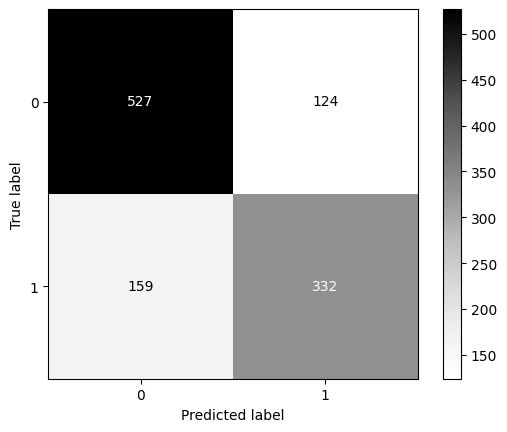

In [467]:
#confussion matrix
cm = confusion_matrix(y_test, y_pred_seq2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp2.plot(cmap='Greys')
plt.show()

Insight :

1. Masih banyak terjadi misklasifikasi pada class 1 (disaster) yang sangat tinggi yaitu hampir 50%
2. Untuk class 0(non disaster) sudah lumayan tidak banyak terjadinya misklasifikasi.

# 11 - Model GRU Improvement

## 11.1 - Model Training

Pada model kali ini akan dilakukan seperti LSTM yaitu menggunakan Bidirectional agar model belajar secara 2 arah

In [469]:
# Clear Session

seed = 50
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [470]:
# Penyusunan Model
model_sequential3 = Sequential()

# Layer Text Vectorization
model_sequential3.add(tweet_vectorization)
# Layer Embedding
model_sequential3.add(embedding_basemodel)
# Hidden Layer 1
model_sequential3.add(tf.keras.layers.Bidirectional(GRU(128,return_sequences=True)))
# Hidden Layer 2
model_sequential3.add(tf.keras.layers.Bidirectional(GRU(64, return_sequences=True)))
# Hidden Layer 3
model_sequential3.add(tf.keras.layers.Bidirectional(GRU(32,return_sequences=True)))

# Hidden Layer 4
model_sequential3.add(tf.keras.layers.Bidirectional(GRU(16,return_sequences=False)))

# Layer Output
model_sequential3.add(Dense(1,activation='sigmoid'))

# Compile
model_sequential3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Summary
model_sequential3.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 24, 128)           1559424   
                                                                 
 bidirectional (Bidirectiona  (None, 24, 256)          198144    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 128)          123648    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 24, 64)           31104     
 nal)                                                   

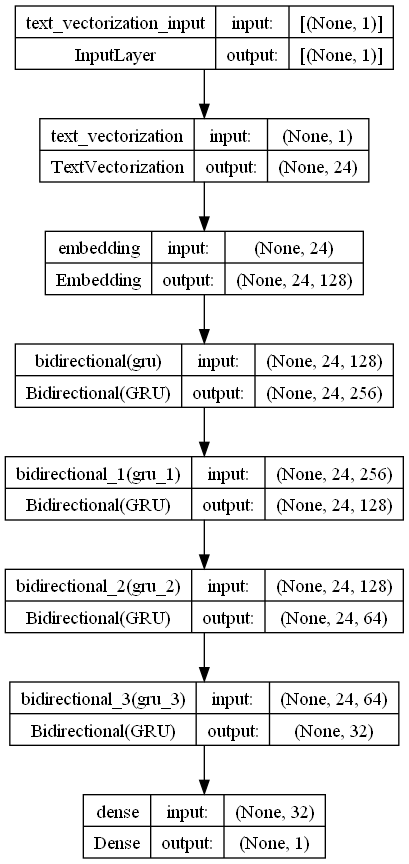

In [471]:
# Plot Layers
tf.keras.utils.plot_model(model_sequential3, show_shapes=True)

In [472]:
model_sequential_gru_improvement = model_sequential3.fit(train_pipe,epochs=10,validation_data = val_pipe)

Epoch 1/10
172/172 [==============================] - 58s 162ms/step - loss: 0.0753 - accuracy: 0.9753 - val_loss: 1.0786 - val_accuracy: 0.7775
Epoch 2/10
172/172 [==============================] - 22s 130ms/step - loss: 0.0410 - accuracy: 0.9833 - val_loss: 1.1341 - val_accuracy: 0.7631
Epoch 3/10
172/172 [==============================] - 22s 130ms/step - loss: 0.0351 - accuracy: 0.9833 - val_loss: 1.2483 - val_accuracy: 0.7817
Epoch 4/10
172/172 [==============================] - 22s 127ms/step - loss: 0.0326 - accuracy: 0.9844 - val_loss: 1.3161 - val_accuracy: 0.7745
Epoch 5/10
172/172 [==============================] - 23s 133ms/step - loss: 0.0338 - accuracy: 0.9831 - val_loss: 1.3003 - val_accuracy: 0.7745
Epoch 6/10
172/172 [==============================] - 22s 127ms/step - loss: 0.0324 - accuracy: 0.9838 - val_loss: 1.0601 - val_accuracy: 0.7806
Epoch 7/10
172/172 [==============================] - 23s 131ms/step - loss: 0.0423 - accuracy: 0.9815 - val_loss: 1.3153 - val_ac

## 11.2 - Model Evaluation

In [473]:
# Create DataFrame

history_seq3_df = pd.DataFrame(model_sequential_gru_improvement.history)
history_seq3_df

loss  accuracy  val_loss  val_accuracy
0  0.075303  0.975273  1.078557      0.777549
1  0.040973  0.983273  1.134134      0.763131
2  0.035117  0.983273  1.248334      0.781668
3  0.032571  0.984364  1.316053      0.774459
4  0.033817  0.983091  1.300283      0.774459
5  0.032445  0.983818  1.060108      0.780639
6  0.042339  0.981455  1.315328      0.761071
7  0.040324  0.980545  0.988406      0.736354
8  0.032705  0.982000  1.494316      0.747683
9  0.037245  0.982000  1.352083      0.759011

<Axes: >

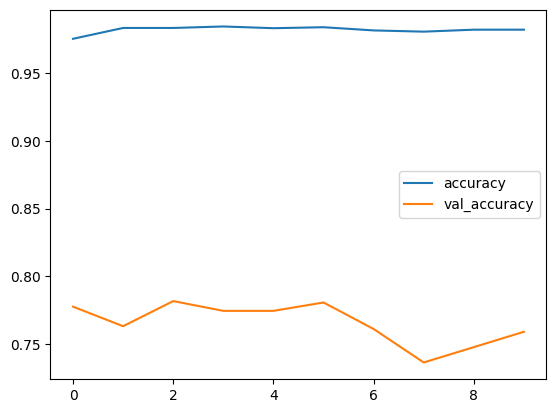

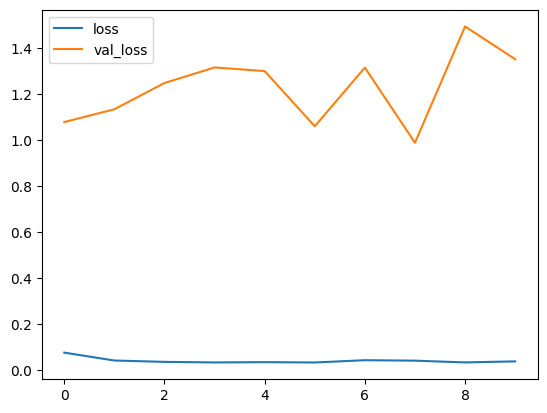

In [474]:
# Plot training results
history_seq3_df[['accuracy','val_accuracy']].plot()
history_seq3_df[['loss','val_loss']].plot()

In [475]:
#classificati report terhadap X_test
y_pred_seq3 = model_sequential3.predict(X_test)
y_pred_seq3 = np.where(y_pred_seq3 >= 0.5,1,0)

print(classification_report(y_test,y_pred_seq3))

36/36 [==============================] - 7s 36ms/step
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       651
           1       0.69      0.67      0.68       491

    accuracy                           0.73      1142
   macro avg       0.72      0.72      0.72      1142
weighted avg       0.73      0.73      0.73      1142



Insight :

1. Accuracy pada data train sangatlah tinggi 98% sedangkan pada data val set hanya 75% (mendapati penurunan dari sebelumnya)
2. Dapat dilihat bahwa loss pada data val sangatlah tinggi jika dibandingkan dengan data train.
3. Data tergolong sangat over-fit

Saran :

pada data ini jika ingin menemukan nilai loss yang lebih kecil pada nilai val, dapat dilakukan epoch yang lumayan banyak dan menggunakan GPU yang memadai agar nilai loss pada nilai val tidak terlalu tinggi dan bisa menemukan titik konvergennya.

## 11.3 - Model Analysis

In [485]:
#pembuatan analysis terhadap prediksi dan nilai asli
analysis3 = pd.DataFrame({'nilai_asli': y_test,'prediksi': np.ndarray.flatten(y_pred_seq3)})
df_analysis_improvement1 = pd.concat([pd.DataFrame(X_test), analysis3],axis=1)

df_analysis_improvement1

tweet_preprocessing  nilai_asli  prediksi
1182  australia ashes disaster collapse unfolded tre...           1         1
7515           malaysia pm confirms wreckage belongs mh           1         1
1294                        burned shit outta dirt bike           0         0
6551                  grace god survived shift im tired           0         1
2702   new favorite trivium detonation rrusa soundcloud           0         0
...                                                 ...         ...       ...
1748  motorcyclist bicyclist injured denver collisio...           1         1
1541  google alert emergency units simulate chemical...           0         1
1946                   da judge gave dis girl pm curfew           0         0
6124                        time try always end sinking           0         0
6429  grogparty tony burke lessons suicide bombing imam           1         1

[1142 rows x 3 columns]

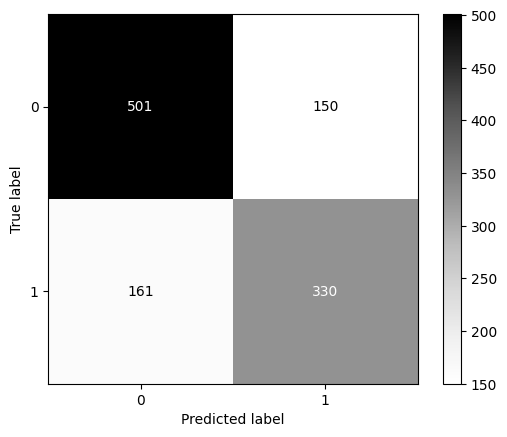

In [479]:
#confussion matrix
cm = confusion_matrix(y_test, y_pred_seq3)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm,)
disp2.plot(cmap='Greys')
plt.show()

Insight : 

1. Terdapat 50% misklasifikasi pada data class 1 (disaster)
2. Pada class 0 terdapat 30% missklasifikasi 

Artinya model ini sudah cukup baik dalam memprediksi apakah data tersebut terindikasi non disaster, namun masih kurang baik untuk memprediksi apakah data tersebut disaster.

# 12 - Select best model & Comparation

In [492]:
# Train Evaluation

eval_training_df = pd.concat([pd.DataFrame(history_seq_df.iloc[-1]).rename(columns={9 :'LSTM Basemodel'}),
                              pd.DataFrame(history_seq2_df.iloc[-1]).rename(columns={9 :'GRU Basemodel'}),
                              pd.DataFrame(history_seq1_df.iloc[-1]).rename(columns={9 :'LSTM Improvement'}),
                              pd.DataFrame(history_seq3_df.iloc[-1]).rename(columns={9 :'GRU Improvement'})],axis=1).T
eval_training_df.round(2).sort_values(by='accuracy', ascending=False)

loss  accuracy  val_loss  val_accuracy
GRU Basemodel     0.03      0.99      1.35          0.77
LSTM Basemodel    0.04      0.98      1.46          0.76
LSTM Improvement  0.03      0.98      1.45          0.77
GRU Improvement   0.04      0.98      1.35          0.76

Insight :

dari ke empat model tersebut model GRU Basemodel merupakan model terbaik karena : 
1. Nilai accuracy yang sangat tinggi 99%
2. Nilai loss yang sangat kecil 0.3%
3. Nilai val_loss yang cenderung kecil dibanding dengan yang lainnya yaitu 1.35
4. Nilai val_accuracy yang tinggi yaitu 77%

# 13 - Model Saving

In [493]:
#freeze the model
model_sequential2.trainable = False
model_sequential2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 24, 128)           1559424   
                                                                 
 gru_23 (GRU)                (None, 24, 128)           99072     
                                                                 
 gru_24 (GRU)                (None, 24, 64)            37248     
                                                                 
 gru_25 (GRU)                (None, 24, 32)            9408      
                                                                 
 gru_26 (GRU)                (None, 16)                2400      
                                                      

In [495]:
model_sequential2.save('best_model')

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


# 14 - Kesimpulan

**EDA Before Preprocessing**

1. Pada data ini lebih banyak non-disaster class dibandingkan dengan disaster class
2. Rata-rata karakter yang digunakan pada tweet yaitu 101 karakter dengan panjang kata 19
3. Rata-rata kata pada disaster maupun non-disaster class berada pada 19 kata per tweet dengan maksimum 39 pada disaster class dan 72 pada non disaster class

**EDA After Prepocessing**
1. Pada data ini tetap sama lebih banyak non-disaster class dibandingkan dengan disaster class
2. Rata-rata karakter yang digunakan pada tweet yaitu 60 karakter dengan panjang kata 9.
3. Rata-rata kata pada disaster maupun non disaster class berada pada 9 kata per tweet dengan maksimum 24 pada disaster class dan 23 pada non disaster class.

**Model Analysis**

Setelah dilakukan 4x permodelan yaitu dengan LSTM dan GRU lalu dilakukan improvement terhadap keduanya didapatkan

Kelebihan :
1. Dari semua model didapatkan tingkat akurasi yang sangat baik yaitu diatas 98%
2. Dari semua model didapatkan juga bahwa tingkat loss sangatlah kecil dengan rata-rata <= 0.43
3. Kesalahan prediksi pada class non disaster sangatlah kecil berada di rentang 10-30%

Kekurangan :
1. Data terlalu overfit, bisa dilihat dari val-loss yang sangat jauh berbeda dengan loss 1.35 --> 0.03
2. Nilai accuracy pada data val sudah lumayan baik yaitu 77% namun masih jauh dibandingkan dengan nilai accuracy pada data train
3. Terlalu banyak missklasifikasi pada prediksi class disaster(1) berada di rentang 30%-50%



**Untuk Improvement Selanjutnya**

1. Permodelan dapat dilakukan pada device yang lebih mumpuni dibanding dengan yang saya gunakan agar epoch pada setiap model bisa lebih banyak untuk mengurangi loss yang tinggi dan mencari konvergensi pada data.
2. Menambahkan beberapa kategori untuk stopwords 
3. Bisa melakukan hybrid layer pada LSTM maupun GRU (tidak menggunakan semua layer sebagai LSTM atau GRU saja)
4. Dapat dilakukan BatchNormalization maupun Drop untuk menambah tingkat akurasi pada data.
5. Melakukan pengurangan maupun penambahan vocabulary pada kata-kata yang sangat umum.
